In [1]:
## 20160521 updated
## roc curves for 2009-2014 data
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [95]:
## def(td,ff,px): # where td is dataframe, ff & px are column names of failflag and probdefault
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

#% time x = auc(px,'f6','Model') ## 0.982024

In [97]:
ctlst2 = list(np.arange(0,2,.1)) + list(np.arange(2,5,.5)) + list(np.arange(5,15,1)) + list(np.arange(15,90,5))
ctlst2 = ctlst2 + list(np.arange(90,97,1)) + list(np.arange(97,99,.5)) + list(np.arange(99,100,.1)) + [100]
ctlst = [np.round(float(x)/100,3) for x in ctlst2]
len(ctlst),ctlst[40:45]

(73,
 [0.34999999999999998,
  0.40000000000000002,
  0.45000000000000001,
  0.5,
  0.55000000000000004])

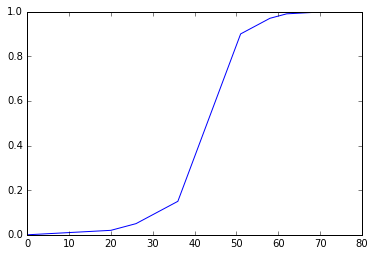

In [98]:
plt.plot(np.arange(len(ctlst)),ctlst)

In [99]:
## function for roc points (ctlst: 73 cuts) (1.1 sec to solve):
def roc(td,ff,px,ct):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list

  xm = pd.DataFrame(columns=['cut','fail', 'surv', 'sens', 'spec', 'FPR'],dtype='float')

  for i in np.arange(len(ct)):
    x1 = ct[i]
    x2 = sum((py[px] > x1)*1)
    x3 = sum((pn[px] > x1)*1)
    x4 = float(x2)/float(ly)
    x5 = float(ln - x3)/float(ln)
    x6 = 1 - x5
    xm=xm.append({'cut':x1,'fail':x2,'surv':x3,'sens':x4,'spec':x5,'FPR':x6},ignore_index=True)

  return xm

#%time xct = roc(px, 'f6', 'Model', ctlst)

In [100]:
### read in all bank data with ratios to run ROC analyses:
dff = pd.read_csv("allbanks_f2468_roe0mm2_20091231.csv",index_col=0)
dff['AsOf'] = pd.to_datetime(dff['AsOf'])
dff['FailDate'] = pd.to_datetime(dff['FailDate'])
dff.head()

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   
2      37 2002-06-30  BANK OF HANCOCK COUNTY    GA  69304.0  0.364757   
3      37 2002-09-30  BANK OF HANCOCK COUNTY    GA  71970.0  0.495989   
4      37 2002-12-31  BANK OF HANCOCK COUNTY    GA  74327.0  0.610962   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385    ...      0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604    ...      0   0   0        1.0   
2  0.206747  4.599485  1.927457  1.294383    ...      0   0   0        1.0   
3  0.325492  4.492631  1.833764  1.235163    ...      0   0   0        1.0   
4  0.268236  4.436347  1.816232  1.214158    ...      0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  1.815612e-08  2.456293e-08  2.654284e-07  1.764341e-08  3.580763e-07   
1  2.072589e-08  2.817566e-08  2.979165e-07  2.060490e-08  4.061476e-07   
2  2.623083e-08  3.536649e-08  3.650533e-07  2.685621e-08  5.024802e-07   
3  4.453468e-08  5.935267e-08  5.789278e-07  4.896556e-08  8.189227e-07   
4  1.604883e-08  2.268381e-08  2.406663e-07  1.580418e-08  3.311848e-07   

       f6_5  
0  0.000002  
1  0.000002  
2  0.000003  
3  0.000004  
4  0.000002  

[5 rows x 33 columns]

In [101]:
prm0 = pd.read_csv("f246_params_roe0mm2_2009.csv",index_col=0)
#prm225 = pd.read_csv("f246_params_alt225mm_2009.csv",index_col=0)

In [102]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
1  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517801   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520142   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611861 -2.799513 -0.473053 -0.024954  0.084635  0.034710  
1   lnTotAst  0.605720 -6.621654 -0.450486 -0.028629  0.084572  0.310082  
2  eBrok_Dep  0.544656 -2.201036 -0.406007  0.112216 -0.028424  0.041344  
3  eBrok_Dep  0.543210 -0.956072 -0.525634  0.116850 -0.306411  0.038855  
4       rROA  0.460012 -1.300542 -0.419816  0.145885  0.042008 -0.286718  
5       rROE  0.458435 -2.075058 -0.346648  0.140151  0.043325 -0.025627

In [103]:
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [104]:
fcol = [x for x in list(dff.columns) if x[0:1]=='f']
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [105]:
targ = pd.to_datetime('2009-12-31')
thresh = 0 ## no minimum size threshold (not needed)
alt = '' ## or alt = ''
dfh = dff[(dff['AsOf']<=targ)&(dff['eTotAst']>(thresh*1000))]\
      [['IDRSSD','AsOf','Name','FailDate']+xcol+fcol]
#dfr09 = sm.add_constant(dfr09)
len(dfh), len(dff)

(259210, 395257)

In [106]:
dfh[xcol].max()

rcTotLn      3.543633e+03
qnTotLn      1.000000e+02
rNIM         4.160000e+04
rPPNR        5.272914e+02
rROA         3.423426e+02
rROE         5.877828e+02
rEff         5.480120e+07
eLn_Dep      9.934150e+02
aFF_TA       1.534201e+02
eBrok_Dep    1.000000e+02
eT1rb        1.999829e+02
eTotrb       2.268312e+02
eALLL_Ln     1.000000e+02
lnTotAst     2.129349e+01
dtype: float64

In [107]:
dfh[xcol].min()

rcTotLn     -5.000000e-01
qnTotLn      0.000000e+00
rNIM        -1.360000e+04
rPPNR       -6.429146e+01
rROA        -7.697304e+01
rROE        -1.998472e+02
rEff        -3.359000e+08
eLn_Dep      0.000000e+00
aFF_TA      -2.722560e+02
eBrok_Dep    0.000000e+00
eT1rb        0.000000e+00
eTotrb       0.000000e+00
eALLL_Ln     0.000000e+00
lnTotAst     6.486161e+00
dtype: float64

In [108]:
## screening criteria:
dfh.dropna(how='any',inplace=True,subset=dfh.columns[8:])  # delete any ratio columns with NaN values (note columns[8:])
dfh= dfh[dfh['eLn_Dep']<=1000]
dfh= dfh[dfh['eBrok_Dep']<=100]
dfh= dfh[dfh['eALLL_Ln']<=100]
dfh= dfh[dfh['rROE']>=-200]
dfh= dfh[dfh['lnTotAst']>2]
dfh= dfh[dfh['eT1rb']<=200]
len(dfh)

259210

In [109]:
## set fflags to zero if FailDate after targ2 date (12/31/2010); that is, for f4
## increment date by interval:
#targ2 = targ+timedelta(days=365)
targ2 = pd.to_datetime((targ.year+1)*10000 + targ.month*100 + targ.day, format='%Y%m%d')  # handles leap years
dfh.ix[dfh.FailDate>targ2,['f2','f4','f6','f8']] = [0,0,0,0]
targ2

Timestamp('2010-12-31 00:00:00')

In [110]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2011-03-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head(8)

IDRSSD       AsOf                   Name   FailDate  f2  f4  f6  f8
4658    16337 2009-09-30           WAKULLA BANK 2010-10-01   0   0   1   1
4659    16337 2009-12-31           WAKULLA BANK 2010-10-01   0   1   1   1
12588   41647 2009-09-30   FIRST BANKING CENTER 2010-11-19   0   0   1   1
12589   41647 2009-12-31   FIRST BANKING CENTER 2010-11-19   0   1   1   1
16806   54357 2009-09-30  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
16807   54357 2009-12-31  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
36428  117841 2009-09-30   EVERGREEN STATE BANK 2011-01-28   0   0   0   0
36429  117841 2009-12-31   EVERGREEN STATE BANK 2011-01-28   0   0   0   0

In [111]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2012-01-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head()

IDRSSD       AsOf                 Name   FailDate  f2  f4  f6  f8
4658   16337 2009-09-30         WAKULLA BANK 2010-10-01   0   0   1   1
4659   16337 2009-12-31         WAKULLA BANK 2010-10-01   0   1   1   1
6017   20370 2009-09-30  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
6018   20370 2009-12-31  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
7011   23241 2009-09-30      INTEGRA BANK NA 2011-07-29   0   0   0   0

In [112]:
dff.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'State', u'eTotAst', u'rcTotLn',
       u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep',
       u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst',
       u'FailDate', u'mtf', u'mtf2', u'f2', u'f4', u'f6', u'f8', u'Intercept',
       u'f2_0', u'f2_1', u'f4_2', u'f4_3', u'f6_4', u'f6_5'],
      dtype='object')

In [113]:
dfh.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'FailDate', u'rcTotLn', u'qnTotLn',
       u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep', u'aFF_TA',
       u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst', u'f2',
       u'f4', u'f6', u'f8', u'f2_0', u'f2_1', u'f4_2', u'f4_3', u'f6_4',
       u'f6_5'],
      dtype='object')

In [114]:
### generate forecasts for all 4-var models:
dv4 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4 = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])

for idx, row in prm0.iterrows():
  fv = row['fx']
  x = idx
  eqnc = fv + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
  res = sm.Logit(yc, Xc).fit()
  dv4 = dv4.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                    'v3':row['v3'],'r3': row['r3'], 'v4':row['v4'],'r4': res.prsquared},ignore_index=True)
  cm = pd.DataFrame(res.params).T
  cm.columns = ['Int','c1','c2','c3','c4']
  cm['idx'] = idx
  cm['v4'] = row['v4']
  cv4 = cv4.append(cm.ix[0])
  pred_tot = res.predict(Xc)
  dfh[fv+'_'+str(x)+'rr'] = pred_tot
  p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
  dff[fv+'_'+str(x)+'rr'] = p_tot

cv4 = cv4.reset_index(drop=True)
dv4 = dv4.reset_index(drop=True)
dv4 = dv4.merge(cv4, how='inner', on=['idx','v4'])


Optimization terminated successfully.
         Current function value: 0.004026
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004090
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010472
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010505
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.018775
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018829
         Iterations 12


In [115]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
1  1.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
2  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517801   
3  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520142   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  5.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611861 -2.799513 -0.473053 -0.024954  0.084635  0.034710  
1   lnTotAst  0.605720 -6.621654 -0.450486 -0.028629  0.084572  0.310082  
2  eBrok_Dep  0.544656 -2.201036 -0.406007  0.112216 -0.028424  0.041344  
3  eBrok_Dep  0.543210 -0.956072 -0.525634  0.116850 -0.306411  0.038855  
4       rROA  0.460012 -1.300542 -0.419816  0.145885  0.042008 -0.286718  
5       rROE  0.458435 -2.075058 -0.346648  0.140151  0.043325 -0.025627

In [116]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
1  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517801   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520142   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611861 -2.799513 -0.473053 -0.024954  0.084635  0.034710  
1   lnTotAst  0.605720 -6.621654 -0.450486 -0.028629  0.084572  0.310082  
2  eBrok_Dep  0.544656 -2.201036 -0.406007  0.112216 -0.028424  0.041344  
3  eBrok_Dep  0.543210 -0.956072 -0.525634  0.116850 -0.306411  0.038855  
4       rROA  0.460012 -1.300542 -0.419816  0.145885  0.042008 -0.286718  
5       rROE  0.458435 -2.075058 -0.346648  0.140151  0.043325 -0.025627

In [117]:
dv4.to_csv("modelrerun_f246_params_roe0mm2_2009.csv")

In [118]:
fcolrr = [x for x in list(dff.columns) if x[0:1]=='f']
fcolrr

['f2',
 'f4',
 'f6',
 'f8',
 'f2_0',
 'f2_1',
 'f4_2',
 'f4_3',
 'f6_4',
 'f6_5',
 'f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr']

In [119]:
dffsum=dff[['AsOf']+fcolrr].groupby('AsOf').sum()
dffsum.ix['2009':'2010']

f2   f4   f6   f8       f2_0       f2_1        f4_2        f4_3  \
AsOf                                                                          
2009-03-31  55  127  197  248  39.918062  38.468210   91.285071   92.507745   
2009-06-30  59  131  189  232  49.092300  50.076222  109.048639  106.968949   
2009-09-30  52  119  170  213  48.978526  50.294342  113.130375  109.504340   
2009-12-31  62  120  163  204  73.303119  74.859618  150.568615  146.838819   
2010-03-31  53  104  146  177  70.683851  74.627545  140.231834  127.024879   
2010-06-30  43   86  127  151  58.258145  63.955326  117.356746  101.372738   
2010-09-30  36   78  108  127  52.635865  58.345715  105.976520   88.207975   
2010-12-31  34   75   99  115  52.011837  56.621819  105.626994   94.541408   

                  f6_4        f6_5     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                   
2009-03-31  136.444662  133.973590  39.918062  38.468210   91.285071   
2009-06-30  154.646575  155.622310  49.092300  50.076222  109.048639   
2009-09-30  161.100308  164.032655  48.978526  50.294342  113.130375   
2009-12-31  197.041137  201.210397  73.303119  74.859618  150.568615   
2010-03-31  172.376513  185.320011  70.683851  74.627545  140.231834   
2010-06-30  142.504080  158.591152  58.258145  63.955326  117.356746   
2010-09-30  125.223577  144.154169  52.635865  58.345715  105.976520   
2010-12-31  129.620304  142.705195  52.011837  56.621819  105.626994   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   92.507745  136.444662  133.973590  
2009-06-30  106.968949  154.646575  155.622310  
2009-09-30  109.504340  161.100308  164.032655  
2009-12-31  146.838819  197.041137  201.210397  
2010-03-31  127.024879  172.376513  185.320011  
2010-06-30  101.372738  142.504080  158.591152  
2010-09-30   88.207975  125.223577  144.154169  
2010-12-31   94.541408  129.620304  142.705195

In [120]:
## single variable models for all fx:
dvv = pd.DataFrame(columns=['fx','v1', 'r1'])
cvv = pd.DataFrame(columns=['fx','v1','Int','c1'])

vr=prm0[['v1','v2','v3','v4']].values
vrlst = list(set(e for r in vr for e in r))  ## list of unique variables among coefficients
vrlst = vrlst + ['eLn_Dep','aFF_TA']

for x in vrlst:
  for y in ['f2','f4','f6']:
    eqnc = y + " ~ " + x  # regression eqn
    pvar = ["Intercept", x]  # var for predictions
    yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
    res = sm.Logit(yc, Xc).fit()
    dvv = dvv.append({'fx':y,'v1':x,'r1':res.prsquared},ignore_index=True)
    cm = pd.DataFrame(res.params).T
    cm.columns = ['Int','c1']
    cm['fx'] = y
    cm['v1'] = x
    cvv = cvv.append(cm)
    pred_tot = res.predict(Xc)
    dfh[y+'_'+x] = pred_tot
    p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
    dff[y+'_'+x] = p_tot

cvv = cvv.reset_index(drop=True)
dvv = dvv.reset_index(drop=True)
dvv = dvv.merge(cvv, how='inner', on=['fx','v1'])

Optimization terminated successfully.
         Current function value: 0.010080
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.022299
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033651
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.005303
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.013873
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024339
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.008952
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.019656
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030498
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.0

In [121]:
dvv

fx         v1        r1        Int        c1
0   f2   lnTotAst  0.028233 -11.176789  0.374696
1   f4   lnTotAst  0.030360 -10.167129  0.368479
2   f6   lnTotAst  0.032131  -9.661138  0.367514
3   f2       rROE  0.488795  -7.358052 -0.056345
4   f4       rROE  0.396744  -6.084051 -0.059825
5   f6       rROE  0.299965  -5.349211 -0.057429
6   f2       rROA  0.136966  -6.644176 -0.271631
7   f4       rROA  0.145298  -5.700188 -0.326827
8   f6       rROA  0.122823  -5.160596 -0.331130
9   f2      eT1rb  0.522181   2.809685 -0.969876
10  f4      eT1rb  0.399541   3.640299 -0.907987
11  f6      eT1rb  0.292186   2.943719 -0.757253
12  f2    qnTotLn  0.130563  -6.986268  0.164781
13  f4    qnTotLn  0.211410  -6.378276  0.272325
14  f6    qnTotLn  0.207348  -5.908558  0.297713
15  f2  eBrok_Dep  0.056154  -6.927195  0.041727
16  f4  eBrok_Dep  0.066877  -6.009661  0.042884
17  f6  eBrok_Dep  0.074322  -5.526108  0.043971
18  f2    eLn_Dep  0.001881  -6.884747  0.003556
19  f4    eLn_Dep  0.003798  -6.013038  0.004215
20  f6    eLn_Dep  0.006362  -5.573603  0.004813
21  f2     aFF_TA  0.002738  -6.700089  0.019721
22  f4     aFF_TA  0.000844  -5.720939  0.011124
23  f6     aFF_TA  0.000002  -5.171728 -0.000568

In [122]:
dvv.to_csv("SingleVar_params_roe0mm2_2009.csv")

In [123]:
dff.to_csv("allbanks_f2468_roe0mm2_20091231_singles.csv",index_col=0)
dfh.to_csv("modelbanks_f2468_roe0mm2_2009_singles.csv",index_col=0)

In [124]:
len(dff), len(dfh)

(395257, 259210)

In [125]:
fcol = [x for x in list(dff.columns) if x[0]=='f']
fcol[10:26]

['f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr',
 'f2_lnTotAst',
 'f4_lnTotAst',
 'f6_lnTotAst',
 'f2_rROE',
 'f4_rROE',
 'f6_rROE',
 'f2_rROA',
 'f4_rROA',
 'f6_rROA',
 'f2_eT1rb']

In [126]:
fnbr = dff[['AsOf']+fcol[0:5]+fcol[10:16]].groupby('AsOf').sum()
fnbr['2009':'2011']

f2   f4   f6   f8       f2_0     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                         
2009-03-31  55  127  197  248  39.918062  39.918062  38.468210   91.285071   
2009-06-30  59  131  189  232  49.092300  49.092300  50.076222  109.048639   
2009-09-30  52  119  170  213  48.978526  48.978526  50.294342  113.130375   
2009-12-31  62  120  163  204  73.303119  73.303119  74.859618  150.568615   
2010-03-31  53  104  146  177  70.683851  70.683851  74.627545  140.231834   
2010-06-30  43   86  127  151  58.258145  58.258145  63.955326  117.356746   
2010-09-30  36   78  108  127  52.635865  52.635865  58.345715  105.976520   
2010-12-31  34   75   99  115  52.011837  52.011837  56.621819  105.626994   
2011-03-31  32   62   83   93  46.254542  46.254542  51.298543   93.503539   
2011-06-30  25   48   63   74  37.409513  37.409513  42.206487   79.031321   
2011-09-30  19   38   48   60  35.141000  35.141000  40.006978   72.357686   
2011-12-31  18   34   46   54  31.030340  31.030340  34.981022   64.148672   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   92.507745  136.444662  133.973590  
2009-06-30  106.968949  154.646575  155.622310  
2009-09-30  109.504340  161.100308  164.032655  
2009-12-31  146.838819  197.041137  201.210397  
2010-03-31  127.024879  172.376513  185.320011  
2010-06-30  101.372738  142.504080  158.591152  
2010-09-30   88.207975  125.223577  144.154169  
2010-12-31   94.541408  129.620304  142.705195  
2011-03-31   79.352067  110.580152  126.059263  
2011-06-30   64.193686   92.269040  109.006570  
2011-09-30   58.128207   82.706066   98.799902  
2011-12-31   55.947444   78.236779   88.698890

In [127]:
dffg = dff[dff['AsOf']>'2009-01-01'][['AsOf']+fcol]

In [128]:
len(dffg)

165272

In [129]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
405035 2014-12-31   0   0   0   0  6.652411e-05  1.132886e-04  2.988429e-04   
405039 2014-09-30   0   0   0   0  2.950490e-40  8.410473e-39  9.176465e-35   

                f4_3          f6_4    ...      f6_qnTotLn  f2_eBrok_Dep  \
405035  1.889888e-04  5.964080e-04    ...        0.002709       0.00098   
405039  4.965197e-52  3.502424e-43    ...        0.002709       0.00098   

        f4_eBrok_Dep  f6_eBrok_Dep  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  \
405035      0.002449      0.003966    0.001349    0.003387    0.005496   
405039      0.002449      0.003966    0.001022    0.002441    0.003782   

        f2_aFF_TA  f4_aFF_TA  f6_aFF_TA  
405035   0.002034   0.004336   0.005562  
405039   0.001229   0.003266   0.005643  

[2 rows x 41 columns]

In [130]:
dffg[['f4','f6']].groupby('f4').count()

f6
f4        
0   164041
1     1231

In [131]:
dff[['f4','f6']].groupby('f4').count()

f6
f4        
0   393629
1     1628

In [132]:
%time xc = roc(dffg, 'f4', 'f4_2', ctlst)

Wall time: 1.55 s


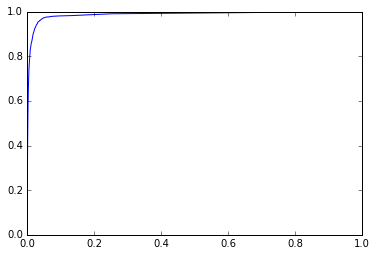

In [133]:
plt.plot(xc['FPR'],xc['sens'],c='b')

In [136]:
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py = td[td[ff]==1][[px,ff]]
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

%time x = auc(dffg, 'f4', 'f4_2rr')

Wall time: 21 s


In [137]:
x

0.9875846407620025

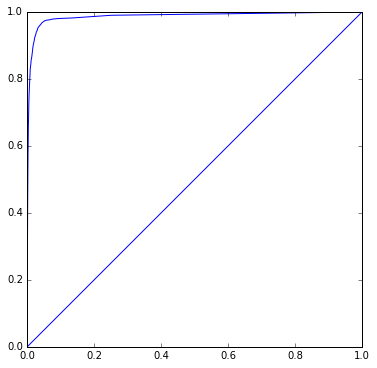

In [138]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,1],[0,1])
plt.plot(xc['FPR'],xc['sens'],c='b')
plt.show()

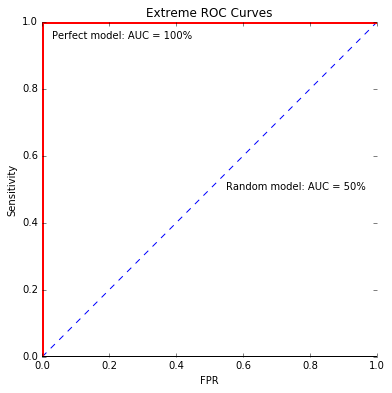

In [139]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.axes(frameon=False)
plt.plot([0,1],[0,1],ls='--',c='b')
plt.plot([0,0,1],[0,1,1],lw=3,c='r')
plt.plot([0,1],[0,0],lw = 2,c='k')
plt.xlabel('FPR')
plt.ylabel('Sensitivity')

plt.annotate('Perfect model: AUC = 100%', xy=(.03,.95))
plt.annotate('Random model: AUC = 50%', xy=(.55,.5))

plt.title('Extreme ROC Curves')
plt.show()

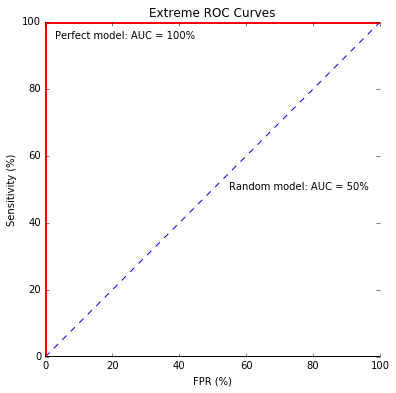

In [140]:
from matplotlib.ticker import FuncFormatter

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.axes(frameon=False)

plt.plot([0,100],[0,100],ls='--',c='b')
plt.plot([0,0,100],[0,100,100],lw=3,c='r')
plt.plot([0,100],[0,0],lw = 2,c='k')
plt.xlabel('FPR (%)')
plt.ylabel('Sensitivity (%)')
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

plt.annotate('Perfect model: AUC = 100%', xy=(3,95))
plt.annotate('Random model: AUC = 50%', xy=(55,50))

plt.title('Extreme ROC Curves')
plt.savefig('ROC_extremecurves.png', dpi=300, bbox_inches='tight')
plt.show()

In [141]:
f4lst=[x for x in list(dffg.columns) if x[0:2]=='f4']  ## all f4 columns
fxlst= [x for x in f4lst if x not in ['f4','f4_2','f4_3','f4_aFF_TA']]  ## no f4; only vars used in models plus 2 dummy vars
f4lst, fxlst

(['f4',
  'f4_2',
  'f4_3',
  'f4_2rr',
  'f4_3rr',
  'f4_lnTotAst',
  'f4_rROE',
  'f4_rROA',
  'f4_eT1rb',
  'f4_qnTotLn',
  'f4_eBrok_Dep',
  'f4_eLn_Dep',
  'f4_aFF_TA'],
 ['f4_2rr',
  'f4_3rr',
  'f4_lnTotAst',
  'f4_rROE',
  'f4_rROA',
  'f4_eT1rb',
  'f4_qnTotLn',
  'f4_eBrok_Dep',
  'f4_eLn_Dep'])

In [142]:
f4auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in fxlst:
  y = auc(dffg, 'f4', x)
  f4auc=f4auc.append({'modvar':x,'auc':y, 'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f4_2rr
f4_3rr
f4_lnTotAst
f4_rROE
f4_rROA
f4_eT1rb
f4_qnTotLn
f4_eBrok_Dep
f4_eLn_Dep


In [143]:
f4auc['aucs'] = f4auc.apply(lambda x: str(np.round(x['auc']*100,1)),axis=1)
f4auc

modvar       auc  aucs
0        f4_2rr  0.987585  98.8
1        f4_3rr  0.987327  98.7
2   f4_lnTotAst  0.570266  57.0
3       f4_rROE  0.975766  97.6
4       f4_rROA  0.965372  96.5
5      f4_eT1rb  0.978501  97.9
6    f4_qnTotLn  0.950011  95.0
7  f4_eBrok_Dep  0.621568  62.2
8    f4_eLn_Dep  0.569009  56.9

In [144]:
f4auc.to_csv("f4auc_roe0mm2_2009_14.csv")

In [145]:
f6lst0=[x for x in list(dffg.columns) if x[0:2]=='f6']  ## all f4 columns
f6lst= [x for x in f6lst0 if x not in ['f6','f6_4','f6_5','f6_aFF_TA']] 
f6lst

['f6_4rr',
 'f6_5rr',
 'f6_lnTotAst',
 'f6_rROE',
 'f6_rROA',
 'f6_eT1rb',
 'f6_qnTotLn',
 'f6_eBrok_Dep',
 'f6_eLn_Dep']

In [146]:
f6auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f6lst:
  y = auc(dffg, 'f6', x)
  f6auc=f6auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f6_4rr
f6_5rr
f6_lnTotAst
f6_rROE
f6_rROA
f6_eT1rb
f6_qnTotLn
f6_eBrok_Dep
f6_eLn_Dep


In [147]:
f2lst0=[x for x in list(dffg.columns) if x[0:2]=='f2']  ## all f4 columns
f2lst= [x for x in f2lst0 if x not in ['f2','f2_0','f2_1','f2_aFF_TA']] 
f2lst

['f2_0rr',
 'f2_1rr',
 'f2_lnTotAst',
 'f2_rROE',
 'f2_rROA',
 'f2_eT1rb',
 'f2_qnTotLn',
 'f2_eBrok_Dep',
 'f2_eLn_Dep']

In [148]:
f2auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f2lst:
  y = auc(dffg, 'f2', x)
  f2auc=f2auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f2_0rr
f2_1rr
f2_lnTotAst
f2_rROE
f2_rROA
f2_eT1rb
f2_qnTotLn
f2_eBrok_Dep
f2_eLn_Dep


In [149]:
f2auc

modvar       auc  aucs
0        f2_0rr  0.990646  99.1
1        f2_1rr  0.988472  98.8
2   f2_lnTotAst  0.565363  56.5
3       f2_rROE  0.980688  98.1
4       f2_rROA  0.969172  96.9
5      f2_eT1rb  0.985326  98.5
6    f2_qnTotLn  0.954710  95.5
7  f2_eBrok_Dep  0.597368  59.7
8    f2_eLn_Dep  0.541765  54.2

In [150]:
f2auc.to_csv("f2auc_roe0mm2_2009_14.csv")

In [151]:
f6auc.to_csv("f6auc_roe0mm2_2009_14.csv")

In [152]:
f6auc

modvar       auc  aucs
0        f6_4rr  0.984341  98.4
1        f6_5rr  0.984508  98.5
2   f6_lnTotAst  0.571307  57.1
3       f6_rROE  0.967184  96.7
4       f6_rROA  0.958505  95.9
5      f6_eT1rb  0.969769  97.0
6    f6_qnTotLn  0.942294  94.2
7  f6_eBrok_Dep  0.633157  63.3
8    f6_eLn_Dep  0.587335  58.7

In [153]:
%time y = roc(dffg, 'f4', 'f4_2rr',ctlst)

Wall time: 1.49 s


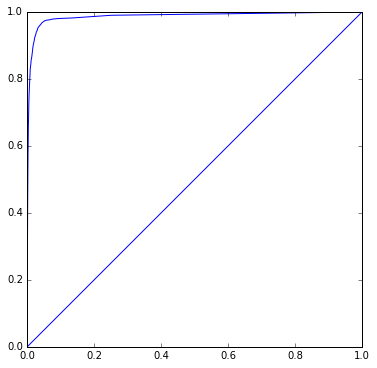

In [154]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,1],[0,1])
plt.plot(y['FPR'],y['sens'],c='b')
plt.show()

In [155]:
#f4roc:
for i in np.arange(len(fxlst)):
#for i in np.arange(2):
  v = fxlst[i]
  y = roc(dffg, 'f4', v, ctlst)
  if i == 0:
    f4roc = y[['cut','sens','FPR']]
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f4roc = f4roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f4roc.to_csv("f4rocpts_roe0mm2_2009_14.csv")
f4roc.head()    

cut  f4_2rr_sens  f4_2rr_FPR  f4_3rr_sens  f4_3rr_FPR  f4_lnTotAst_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000          1.000000   
1  0.001     0.990252    0.251742     0.988627    0.219921          1.000000   
2  0.002     0.982128    0.132839     0.982128    0.126023          0.924452   
3  0.003     0.980504    0.093830     0.978879    0.090910          0.665313   
4  0.004     0.978879    0.075694     0.977254    0.074042          0.368806   

   f4_lnTotAst_FPR  f4_rROE_sens  f4_rROE_FPR  f4_rROA_sens  f4_rROA_FPR  \
0         1.000000      1.000000     1.000000      1.000000     1.000000   
1         0.997970      0.993501     0.865217      1.000000     0.991447   
2         0.881383      0.979691     0.238416      0.995938     0.889552   
3         0.548363      0.969131     0.114929      0.982128     0.274419   
4         0.291202      0.964257     0.083174      0.959383     0.108107   

   f4_eT1rb_sens  f4_eT1rb_FPR  f4_qnTotLn_sens  f4_qnTotLn_FPR  \
0       1.000000      1.000000         1.000000        1.000000   
1       0.975630      0.206899         1.000000        1.000000   
2       0.969131      0.134637         0.989439        0.651477   
3       0.963444      0.100115         0.967506        0.321328   
4       0.959383      0.078858         0.947197        0.207180   

   f4_eBrok_Dep_sens  f4_eBrok_Dep_FPR  f4_eLn_Dep_sens  f4_eLn_Dep_FPR  
0           1.000000          1.000000         1.000000        1.000000  
1           1.000000          1.000000         1.000000        1.000000  
2           1.000000          1.000000         1.000000        1.000000  
3           0.504468          0.198700         0.974817        0.881170  
4           0.320877          0.090252         0.008936        0.013838

In [156]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
405035 2014-12-31   0   0   0   0  6.652411e-05  1.132886e-04  2.988429e-04   
405039 2014-09-30   0   0   0   0  2.950490e-40  8.410473e-39  9.176465e-35   

                f4_3          f6_4    ...      f6_qnTotLn  f2_eBrok_Dep  \
405035  1.889888e-04  5.964080e-04    ...        0.002709       0.00098   
405039  4.965197e-52  3.502424e-43    ...        0.002709       0.00098   

        f4_eBrok_Dep  f6_eBrok_Dep  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  \
405035      0.002449      0.003966    0.001349    0.003387    0.005496   
405039      0.002449      0.003966    0.001022    0.002441    0.003782   

        f2_aFF_TA  f4_aFF_TA  f6_aFF_TA  
405035   0.002034   0.004336   0.005562  
405039   0.001229   0.003266   0.005643  

[2 rows x 41 columns]

In [157]:
######### CAUTION ############################################
# shortcut to skip earlier processing and get to charts below
##############################################################

## read auc files:
#f2auc= pd.read_csv("f2auc_roe0mm2_2009_14.csv",index_col=0)
#f4auc= pd.read_csv("f4auc_roe0mm2_2009_14.csv",index_col=0)
#f6auc= pd.read_csv("f6auc_roe0mm2_2009_14.csv",index_col=0)
#f2auc['aucs'] = f2auc['aucs'].astype(str)
#f4auc['aucs'] = f4auc['aucs'].astype(str)
#f6auc['aucs'] = f6auc['aucs'].astype(str)

## read roc files:
#f2roc= pd.read_csv("f2rocpts_roe0mm2_2009.csv",index_col=0)
#f4roc= pd.read_csv("f4rocpts_roe0mm2_2009.csv",index_col=0)
#f6roc= pd.read_csv("f6rocpts_roe0mm2_2009.csv",index_col=0)

In [158]:
f2auc.dtypes

modvar     object
auc       float64
aucs       object
dtype: object

In [159]:
f4roc.columns

Index([u'cut', u'f4_2rr_sens', u'f4_2rr_FPR', u'f4_3rr_sens', u'f4_3rr_FPR',
       u'f4_lnTotAst_sens', u'f4_lnTotAst_FPR', u'f4_rROE_sens',
       u'f4_rROE_FPR', u'f4_rROA_sens', u'f4_rROA_FPR', u'f4_eT1rb_sens',
       u'f4_eT1rb_FPR', u'f4_qnTotLn_sens', u'f4_qnTotLn_FPR',
       u'f4_eBrok_Dep_sens', u'f4_eBrok_Dep_FPR', u'f4_eLn_Dep_sens',
       u'f4_eLn_Dep_FPR'],
      dtype='object')

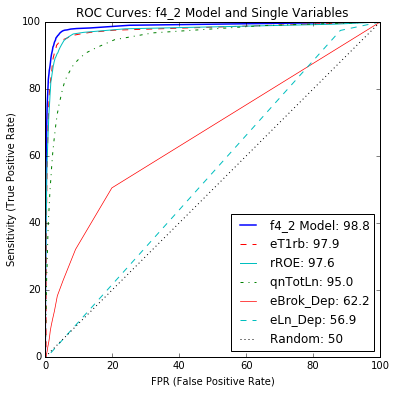

In [160]:
## Code to resize chart frame !!!!!!
#f4auc['aucs'] = f4auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f4roc['f4_2rr_FPR']*100,f4roc['f4_2rr_sens']*100,c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR']*100,f4roc['f4_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR']*100,f4roc['f4_rROE_sens']*100,c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR']*100,f4roc['f4_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR']*100,f4roc['f4_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
plt.plot(f4roc['f4_eLn_Dep_FPR']*100,f4roc['f4_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f4_2 Model and Single Variables')
plt.savefig('ROC_f4_roe0mm2_2009_14.png', dpi=300, bbox_inches='tight')
plt.show()

In [161]:
#f6roc:
for i in np.arange(len(f6lst)):
#for i in np.arange(2):
  v = f6lst[i]
  y = roc(dffg, 'f6', v, ctlst)
  if i == 0:
    f6roc = y[['cut','sens','FPR']]
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f6roc = f6roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f6roc.to_csv("f6rocpts_roe0mm2_2009_14.csv")
f6roc.head()    

cut  f6_4rr_sens  f6_4rr_FPR  f6_5rr_sens  f6_5rr_FPR  f6_lnTotAst_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000          1.000000   
1  0.001     0.995362    0.421616     0.995362    0.477429          1.000000   
2  0.002     0.988406    0.274514     0.991304    0.304359          0.999420   
3  0.003     0.987826    0.196005     0.986087    0.209059          0.960580   
4  0.004     0.980870    0.150464     0.982029    0.156414          0.842319   

   f6_lnTotAst_FPR  f6_rROE_sens  f6_rROE_FPR  f6_rROA_sens  f6_rROA_FPR  \
0         1.000000      1.000000     1.000000      1.000000     1.000000   
1         0.999969      0.998261     0.989942      1.000000     0.994069   
2         0.993030      0.993043     0.896391      1.000000     0.989129   
3         0.922713      0.984348     0.592093      0.996522     0.948437   
4         0.746532      0.973333     0.272356      0.989565     0.713575   

   f6_eT1rb_sens  f6_eT1rb_FPR  f6_qnTotLn_sens  f6_qnTotLn_FPR  \
0       1.000000      1.000000         1.000000        1.000000   
1       0.976232      0.349196         1.000000        1.000000   
2       0.969275      0.252961         1.000000        1.000000   
3       0.961159      0.198512         0.988406        0.738491   
4       0.957681      0.161177         0.973913        0.461256   

   f6_eBrok_Dep_sens  f6_eBrok_Dep_FPR  f6_eLn_Dep_sens  f6_eLn_Dep_FPR  
0           1.000000          1.000000              1.0         1.00000  
1           1.000000          1.000000              1.0         1.00000  
2           1.000000          1.000000              1.0         1.00000  
3           1.000000          1.000000              1.0         1.00000  
4           0.717101          0.393752              1.0         0.99007

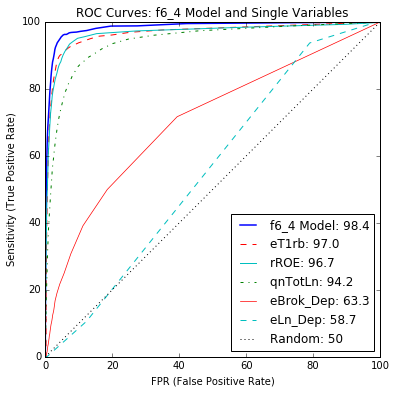

In [162]:
## Code to resize chart frame !!!!!!
#f6auc['aucs'] = f6auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f6roc['f6_4rr_FPR']*100,f6roc['f6_4rr_sens']*100,c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR']*100,f6roc['f6_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR']*100,f6roc['f6_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR']*100,f6roc['f6_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR']*100,f6roc['f6_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
plt.plot(f6roc['f6_eLn_Dep_FPR']*100,f6roc['f6_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f6_4 Model and Single Variables')
plt.savefig('ROC_f6_roe0mm2_2009_14.png', dpi=300, bbox_inches='tight')
plt.show()

In [163]:
#f2roc:
for i in np.arange(len(f2lst)):
#for i in np.arange(2):
  v = f2lst[i]
  y = roc(dffg, 'f2', v, ctlst)
  if i == 0:
    f2roc = y[['cut','sens','FPR']]
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f2roc = f2roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f2roc.to_csv("f2rocpts_roe0mm2_2009_14.csv")
f2roc.head()    

cut  f2_0rr_sens  f2_0rr_FPR  f2_1rr_sens  f2_1rr_FPR  f2_lnTotAst_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000          1.000000   
1  0.001     0.980066    0.073213     0.978405    0.081484          0.792359   
2  0.002     0.978405    0.048412     0.975083    0.051315          0.205980   
3  0.003     0.976744    0.039473     0.973422    0.041289          0.078073   
4  0.004     0.968439    0.034609     0.970100    0.035647          0.031561   

   f2_lnTotAst_FPR  f2_rROE_sens  f2_rROE_FPR  f2_rROA_sens  f2_rROA_FPR  \
0         1.000000      1.000000     1.000000      1.000000     1.000000   
1         0.708447      0.975083     0.094729      0.988372     0.653592   
2         0.157800      0.968439     0.048697      0.925249     0.058772   
3         0.053471      0.955150     0.036455      0.749169     0.026295   
4         0.028129      0.951827     0.030097      0.588040     0.015133   

   f2_eT1rb_sens  f2_eT1rb_FPR  f2_qnTotLn_sens  f2_qnTotLn_FPR  \
0       1.000000      1.000000         1.000000        1.000000   
1       0.975083      0.077962         0.990033        0.693223   
2       0.973422      0.045795         0.920266        0.120763   
3       0.965116      0.035404         0.845515        0.056847   
4       0.956811      0.031287         0.742525        0.036315   

   f2_eBrok_Dep_sens  f2_eBrok_Dep_FPR  f2_eLn_Dep_sens  f2_eLn_Dep_FPR  
0           1.000000          1.000000              1.0        1.000000  
1           0.659468          0.372059              1.0        1.000000  
2           0.187708          0.052013              0.0        0.001172  
3           0.107973          0.023362              0.0        0.000383  
4           0.066445          0.014289              0.0        0.000249

In [164]:
f2roc.columns

Index([u'cut', u'f2_0rr_sens', u'f2_0rr_FPR', u'f2_1rr_sens', u'f2_1rr_FPR',
       u'f2_lnTotAst_sens', u'f2_lnTotAst_FPR', u'f2_rROE_sens',
       u'f2_rROE_FPR', u'f2_rROA_sens', u'f2_rROA_FPR', u'f2_eT1rb_sens',
       u'f2_eT1rb_FPR', u'f2_qnTotLn_sens', u'f2_qnTotLn_FPR',
       u'f2_eBrok_Dep_sens', u'f2_eBrok_Dep_FPR', u'f2_eLn_Dep_sens',
       u'f2_eLn_Dep_FPR'],
      dtype='object')

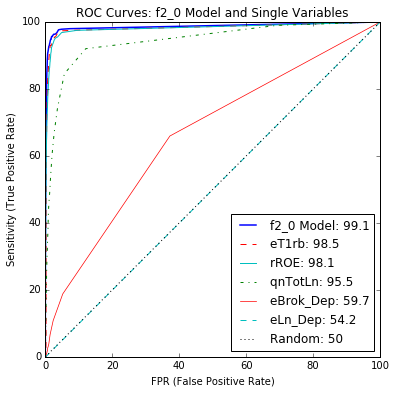

In [165]:
## Code to resize chart frame !!!!!!
#f2auc['aucs'] = f2auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f2roc['f2_0rr_FPR']*100,f2roc['f2_0rr_sens']*100,c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR']*100,f2roc['f2_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR']*100,f2roc['f2_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR']*100,f2roc['f2_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR']*100,f2roc['f2_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
plt.plot(f2roc['f2_eLn_Dep_FPR']*100,f2roc['f2_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f2_0 Model and Single Variables')
plt.savefig('ROC_f2_roe0mm2_2009_14.png', dpi=300, bbox_inches='tight')
plt.show()

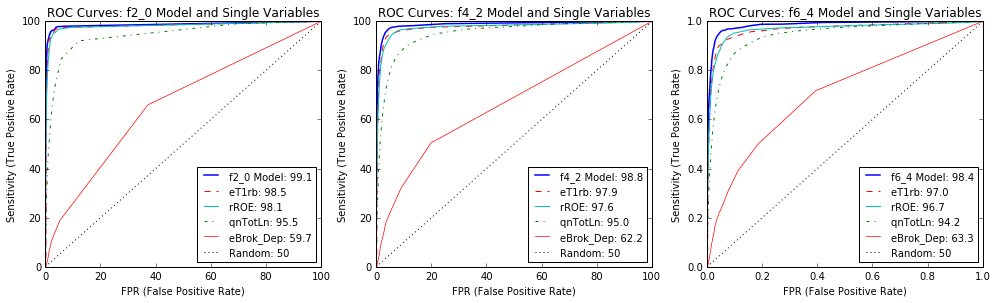

In [166]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.8, plSize[1]*1.1) )  ## double width, single height

plt.subplot(1, 3, 1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plt.plot(f2roc['f2_0rr_FPR']*100,f2roc['f2_0rr_sens']*100,c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR']*100,f2roc['f2_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR']*100,f2roc['f2_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR']*100,f2roc['f2_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR']*100,f2roc['f2_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
#plt.plot(f2roc['f2_eLn_Dep_FPR'],f2roc['f2_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4, fontsize=10)
plt.title('ROC Curves: f2_0 Model and Single Variables')

plt.subplot(1, 3, 2)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plt.plot(f4roc['f4_2rr_FPR']*100,f4roc['f4_2rr_sens']*100,c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR']*100,f4roc['f4_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR']*100,f4roc['f4_rROE_sens']*100,c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR']*100,f4roc['f4_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR']*100,f4roc['f4_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
#plt.plot(f4roc['f4_eLn_Dep_FPR'],f4roc['f4_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4,fontsize=10)
plt.title('ROC Curves: f4_2 Model and Single Variables')

plt.subplot(1, 3, 3)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plt.plot(f6roc['f6_4rr_FPR'],f6roc['f6_4rr_sens'],c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR'],f6roc['f6_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR'],f6roc['f6_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR'],f6roc['f6_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
#plt.plot(f6roc['f6_eLn_Dep_FPR'],f6roc['f6_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4, fontsize=10)
plt.title('ROC Curves: f6_4 Model and Single Variables')

plt.savefig('ROC_f246_roe0mm2_2009_14.png', dpi=400, bbox_inches='tight')
plt.show()

In [167]:
## identify optimal cut-off point

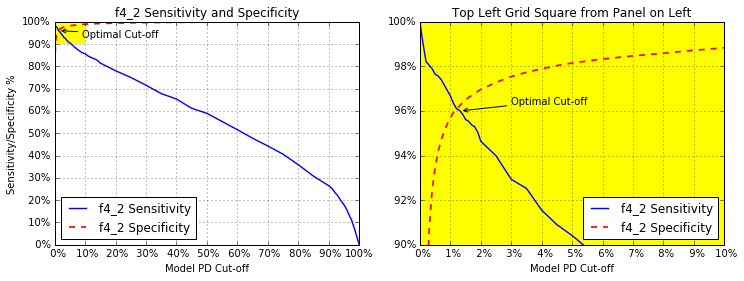

In [168]:
from matplotlib.patches import Rectangle

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.09, .93),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')
plt.savefig('SensSpecOptCut_f4_2_roe0mm2_2009_14.png', dpi=400, bbox_inches='tight')
plt.show()

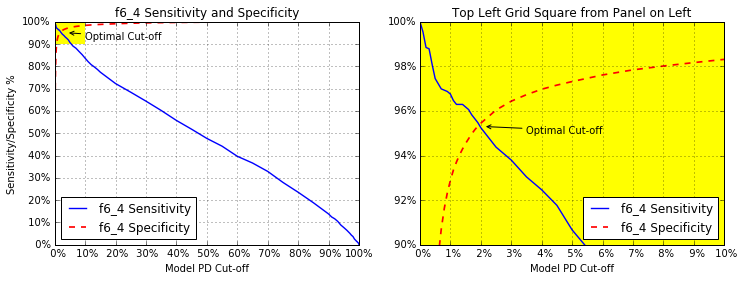

In [169]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.04,.95), xytext=(.1, .92),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.021,.953), xytext=(.035, .95),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')
plt.savefig('SensSpecOptCut_f6_4_roe0mm2_2009_14.png', dpi=400, bbox_inches='tight')
plt.show()

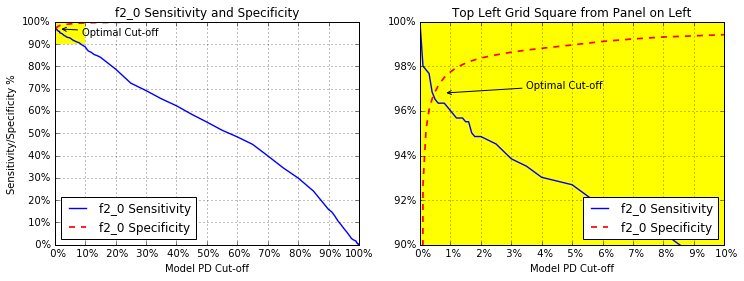

In [170]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.015,.967), xytext=(.09, .94),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.008,.968), xytext=(.035, .97),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')

plt.savefig('SensSpecOptCut_f2_0_roe0mm2_2009_14.png', dpi=400, bbox_inches='tight')
plt.show()


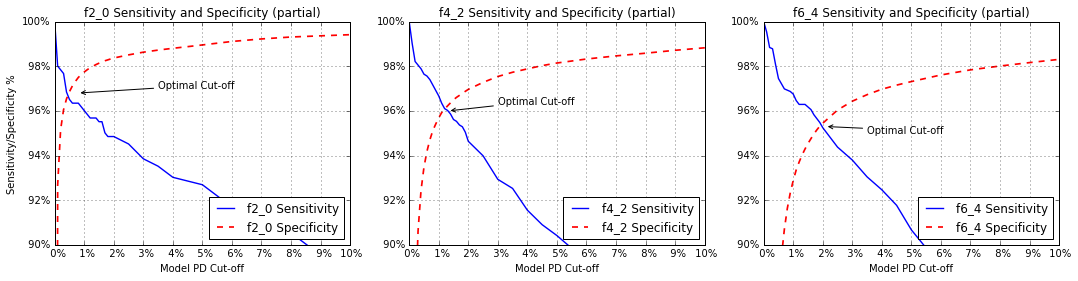

In [171]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 3, 1)
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.ylabel('Sensitivity/Specificity %')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.008,.968), xytext=(.035, .97),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity (partial)')
plt.grid('on')

plt.subplot(1, 3, 2)
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity (partial)')
plt.grid('on')

plt.subplot(1, 3, 3)
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.021,.953), xytext=(.035, .95),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity (partial)')
plt.grid('on')

plt.savefig('SensSpecOptCut_f246partial_roe0mm2_2009_14.png', dpi=400, bbox_inches='tight')
plt.show()

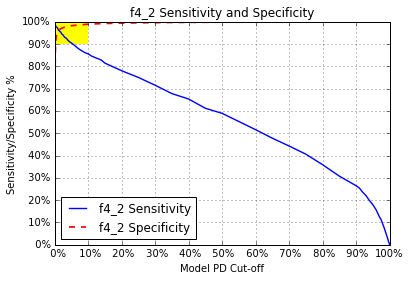

In [172]:
from matplotlib.patches import Rectangle
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.title('f4_2 Sensitivity and Specificity')
plt.grid('on')
plt.show()

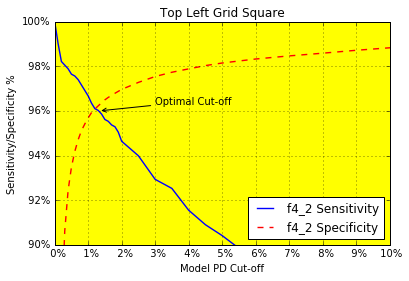

In [173]:
from matplotlib.patches import Rectangle
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.4,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square')
plt.grid('on')
plt.show()

In [174]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
405035 2014-12-31   0   0   0   0  6.652411e-05  1.132886e-04  2.988429e-04   
405039 2014-09-30   0   0   0   0  2.950490e-40  8.410473e-39  9.176465e-35   

                f4_3          f6_4    ...      f6_qnTotLn  f2_eBrok_Dep  \
405035  1.889888e-04  5.964080e-04    ...        0.002709       0.00098   
405039  4.965197e-52  3.502424e-43    ...        0.002709       0.00098   

        f4_eBrok_Dep  f6_eBrok_Dep  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  \
405035      0.002449      0.003966    0.001349    0.003387    0.005496   
405039      0.002449      0.003966    0.001022    0.002441    0.003782   

        f2_aFF_TA  f4_aFF_TA  f6_aFF_TA  
405035   0.002034   0.004336   0.005562  
405039   0.001229   0.003266   0.005643  

[2 rows x 41 columns]

In [175]:
#### section to process problem bank list 12/31/2010:
pbk = pd.read_csv('ProbBank20101231.csv',skiprows=3,encoding='latin1')
pbk['Date'] = pd.to_datetime(pbk['Date'])
pbk['Prompt Corrective Action Date'] = pd.to_datetime(pbk['Prompt Corrective Action Date'])

In [176]:
pbk.head()

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   
2        1149                 116962    SM    FRB   
3        3564                 319321     N    OCC   
4       57157                  83618    NM   FDIC   

                                 Name             City State       Date  \
0                   1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1   1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   
2                  1st Financial Bank    Overland Park    KS 2009-06-22   
3  1st National Bank of South Florida        Homestead    FL 2010-06-29   
4                    1st Regents Bank          Andover    MN 2010-03-24   

  Enforcement Action Type       Reason Prompt Corrective Action  \
0           Consent Order      Capital                      NaN   
1   Supervisory Agreement      General                      NaN   
2       Written Agreement      General                      NaN   
3           Consent Order  CRE lending                      NaN   
4           Consent Order       C&D RE                      NaN   

  Prompt Corrective Action Date Ticker Symbol  
0                           NaT           CBC  
1                           NaT           NaN  
2                           NaT           NaN  
3                           NaT           NaN  
4                           NaT           NaN

In [177]:
pbk['prob'] = 1
pbk.head()

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   
2        1149                 116962    SM    FRB   
3        3564                 319321     N    OCC   
4       57157                  83618    NM   FDIC   

                                 Name             City State       Date  \
0                   1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1   1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   
2                  1st Financial Bank    Overland Park    KS 2009-06-22   
3  1st National Bank of South Florida        Homestead    FL 2010-06-29   
4                    1st Regents Bank          Andover    MN 2010-03-24   

  Enforcement Action Type       Reason Prompt Corrective Action  \
0           Consent Order      Capital                      NaN   
1   Supervisory Agreement      General                      NaN   
2       Written Agreement      General                      NaN   
3           Consent Order  CRE lending                      NaN   
4           Consent Order       C&D RE                      NaN   

  Prompt Corrective Action Date Ticker Symbol  prob  
0                           NaT           CBC     1  
1                           NaT           NaN     1  
2                           NaT           NaN     1  
3                           NaT           NaN     1  
4                           NaT           NaN     1

In [178]:
rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult2015.csv", index_col=0)  # 20160430 update
rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])

In [179]:
pbk = pbk.merge(rk[['xCert','IDRSSD']],how='left',left_on='FDIC Cert#',right_on='xCert')
pbk.head(2)

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   

                                Name             City State       Date  \
0                  1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1  1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   

  Enforcement Action Type   Reason Prompt Corrective Action  \
0           Consent Order  Capital                      NaN   
1   Supervisory Agreement  General                      NaN   

  Prompt Corrective Action Date Ticker Symbol  prob    xCert     IDRSSD  
0                           NaT           CBC     1  58358.0  3465383.0  
1                           NaT           NaN     1  58773.0  3688678.0

In [180]:
dff10 = dff[dff['AsOf']=='2010-12-31']
dff10 = dff10.merge(pbk[['IDRSSD','prob']],how='left',on = 'IDRSSD')
dff10.head(2)

IDRSSD       AsOf                              Name State  eTotAst  \
0      37 2010-12-31            BANK OF HANCOCK COUNTY    GA  83515.0   
1     242 2010-12-31  FIRST COMMUNITY BANK XENIA-FLORA    IL  32756.0   

    rcTotLn   qnTotLn      rNIM     rPPNR      rROA ...   f2_eBrok_Dep  \
0  0.632531  3.814983  3.922807  1.097109  0.743125 ...        0.00098   
1  0.055148  0.271248  4.003830  1.490713  1.555913 ...        0.00098   

   f4_eBrok_Dep  f6_eBrok_Dep  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  f2_aFF_TA  \
0      0.002449      0.003966    0.001304    0.003255    0.005252   0.001325   
1      0.002449      0.003966    0.001451    0.003693    0.006064   0.001265   

   f4_aFF_TA  f6_aFF_TA prob  
0   0.003407   0.005631  NaN  
1   0.003319   0.005638  NaN  

[2 rows x 64 columns]

In [181]:
dff10[['prob','f4','f4_2']].groupby('prob').sum()

f4      f4_2
prob              
1.0   67  82.36532

In [182]:
dff10['prob']=dff10['prob'].fillna(0)

In [183]:
dff10['decile'] = pd.qcut(dff10['f4_2'], 10, labels=False)
dff10[['f4_2','decile']].groupby('decile').mean()

f4_2
decile          
0       0.000001
1       0.000025
2       0.000092
3       0.000207
4       0.000371
5       0.000592
6       0.000898
7       0.001360
8       0.002583
9       0.146955

In [184]:
dff10['decile'] = pd.qcut(dff10['f4_2'], 10, labels=False)
dff10[['f4_2','decile']].groupby('decile').sum()

f4_2
decile            
0         0.000926
1         0.017514
2         0.063657
3         0.142556
4         0.256309
5         0.407796
6         0.619616
7         0.937350
8         1.782051
9       101.399219

In [185]:
dff10p = dff10[dff10['prob']==1]
dff10p['decile'] = pd.qcut(dff10p['f4_2'], 10, labels=False)
dff10p[['f4_2','decile']].groupby('decile').mean()

f4_2
decile          
0       0.000133
1       0.000549
2       0.001026
3       0.001760
4       0.002943
5       0.006379
6       0.015713
7       0.044024
8       0.192275
9       0.730741

In [186]:
dff10p[['f4_2','decile']].groupby('decile').sum()

f4_2
decile           
0        0.011064
1        0.044992
2        0.084171
3        0.144310
4        0.241315
5        0.523062
6        1.288464
7        3.609943
8       15.766527
9       60.651472

In [187]:
dff10p0 = dff10[dff10['prob']==0]
dff10p0['decile'] = pd.qcut(dff10p0['f4_2'], 10, labels=False)
dff10p0[['f4_2','decile']].groupby('decile').mean()

f4_2
decile              
0       9.331671e-07
1       1.836602e-05
2       7.074255e-05
3       1.615511e-04
4       2.929849e-04
5       4.784778e-04
6       7.135886e-04
7       1.056543e-03
8       1.651548e-03
9       3.381957e-02

In [188]:
dff10p0[['f4_2','decile']].groupby('decile').sum()

f4_2
decile           
0        0.000567
1        0.011148
2        0.043011
3        0.098062
4        0.178135
5        0.290436
6        0.433148
7        0.642378
8        1.002489
9       20.562299

In [189]:
#############################################################################
## NOTE:  try Worst 3% & 4% of f4 scores... 
#############################################################################

In [190]:
dq96 = dff[['AsOf','f2_0','f2_1','f4_2','f4_3','f6_4','f6_5']].groupby('AsOf').quantile(.96)
dq96.rename(columns={'f2_0':'w4_2_0','f2_1':'w4_2_1','f4_2':'w4_4_2','f4_3':'w4_4_3','f6_4':'w4_6_4',\
                     'f6_5':'w4_6_5'},inplace=True)
dq97 = dff[['AsOf','f2_0','f2_1','f4_2','f4_3','f6_4','f6_5']].groupby('AsOf').quantile(.97)
dq97.rename(columns={'f2_0':'w3_2_0','f2_1':'w3_2_1','f4_2':'w3_4_2','f4_3':'w3_4_3','f6_4':'w3_6_4',\
                      'f6_5':'w3_6_5'},inplace=True)
dqt = dq97.merge(dq96,how='left',left_index=True,right_index=True)
dqt.ix['2010':'2011']

w3_2_0    w3_2_1    w3_4_2    w3_4_3    w3_6_4    w3_6_5  \
AsOf                                                                     
2010-03-31  0.027353  0.028551  0.126142  0.110169  0.200169  0.216275   
2010-06-30  0.017170  0.017411  0.085626  0.075861  0.147007  0.167528   
2010-09-30  0.014586  0.015121  0.074300  0.064464  0.138704  0.145101   
2010-12-31  0.015847  0.017842  0.068581  0.072753  0.133809  0.129194   
2011-03-31  0.012826  0.014002  0.058013  0.057149  0.105334  0.119683   
2011-06-30  0.010135  0.011350  0.047874  0.046449  0.092227  0.100846   
2011-09-30  0.008906  0.009296  0.042448  0.039362  0.078316  0.086154   
2011-12-31  0.007653  0.008542  0.035641  0.040043  0.079080  0.073912   

              w4_2_0    w4_2_1    w4_4_2    w4_4_3    w4_6_4    w4_6_5  
AsOf                                                                    
2010-03-31  0.011055  0.011666  0.054310  0.051477  0.108818  0.108585  
2010-06-30  0.007962  0.008835  0.040481  0.039191  0.081622  0.083263  
2010-09-30  0.007541  0.008297  0.036125  0.033577  0.077613  0.081198  
2010-12-31  0.008069  0.008437  0.035766  0.039600  0.079778  0.079432  
2011-03-31  0.005777  0.007130  0.028773  0.027929  0.059194  0.058217  
2011-06-30  0.005019  0.005596  0.024822  0.023760  0.051222  0.051710  
2011-09-30  0.003818  0.004243  0.017226  0.017225  0.038495  0.040269  
2011-12-31  0.003207  0.003668  0.015102  0.016008  0.036482  0.034296

In [191]:
### screen for high outliers:
dff[list(set(e for r in dv4[['v1','v2','v3','v4']].values for e in r))].max()
## screen for eT1rb < 200

lnTotAst      21.453218
rROE         974.428135
rROA         370.554643
eT1rb        200.000000
qnTotLn      100.000000
eBrok_Dep    100.000000
dtype: float64

In [192]:
### screen for low outliers:
dff[list(set(e for r in dv4[['v1','v2','v3','v4']].values for e in r))].min()
## screen for lnTotAst > 2

lnTotAst       4.672829
rROE        -200.000000
rROA         -76.973035
eT1rb          0.000000
qnTotLn        0.000000
eBrok_Dep      0.000000
dtype: float64

In [193]:
dffw = dff.merge(dqt,how='left',left_on='AsOf',right_index=True)
dffw['w2_0'] = (dffw['f2_0']>dffw['w4_2_0'])*1 + (dffw['f2_0']>dffw['w3_2_0'])*1
dffw['w2_1'] = (dffw['f2_1']>dffw['w4_2_1'])*1 + (dffw['f2_1']>dffw['w3_2_1'])*1
dffw['w4_2'] = (dffw['f4_2']>dffw['w4_4_2'])*1 + (dffw['f4_2']>dffw['w3_4_2'])*1
dffw['w4_3'] = (dffw['f4_3']>dffw['w4_4_3'])*1 + (dffw['f4_3']>dffw['w3_4_3'])*1
dffw['w6_4'] = (dffw['f6_4']>dffw['w4_6_4'])*1 + (dffw['f6_4']>dffw['w3_6_4'])*1
dffw['w6_5'] = (dffw['f6_5']>dffw['w4_6_5'])*1 + (dffw['f6_5']>dffw['w3_6_5'])*1
dffw.head(2)

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   

    qnTotLn      rNIM     rPPNR      rROA ...     w4_4_2    w4_4_3    w4_6_4  \
0  0.202341  4.771308  2.035791  1.366385 ...   0.003303  0.003925  0.007684   
1  0.199812  4.673793  1.952308  1.314604 ...   0.003164  0.003778  0.007517   

     w4_6_5  w2_0  w2_1  w4_2  w4_3  w6_4 w6_5  
0  0.006749     0     0     0     0     0    0  
1  0.006723     0     0     0     0     0    0  

[2 rows x 81 columns]

In [194]:
dffw[['IDRSSD','w4_2']].groupby('w4_2').count()

IDRSSD
w4_2        
0     379425
1       3947
2      11885

In [195]:
dffw.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'State', u'eTotAst', u'rcTotLn',
       u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep',
       u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst',
       u'FailDate', u'mtf', u'mtf2', u'f2', u'f4', u'f6', u'f8', u'Intercept',
       u'f2_0', u'f2_1', u'f4_2', u'f4_3', u'f6_4', u'f6_5', u'f2_0rr',
       u'f2_1rr', u'f4_2rr', u'f4_3rr', u'f6_4rr', u'f6_5rr', u'f2_lnTotAst',
       u'f4_lnTotAst', u'f6_lnTotAst', u'f2_rROE', u'f4_rROE', u'f6_rROE',
       u'f2_rROA', u'f4_rROA', u'f6_rROA', u'f2_eT1rb', u'f4_eT1rb',
       u'f6_eT1rb', u'f2_qnTotLn', u'f4_qnTotLn', u'f6_qnTotLn',
       u'f2_eBrok_Dep', u'f4_eBrok_Dep', u'f6_eBrok_Dep', u'f2_eLn_Dep',
       u'f4_eLn_Dep', u'f6_eLn_Dep', u'f2_aFF_TA', u'f4_aFF_TA', u'f6_aFF_TA',
       u'w3_2_0', u'w3_2_1', u'w3_4_2', u'w3_4_3', u'w3_6_4', u'w3_6_5',
       u'w4_2_0', u'w4_2_1', u'w4_4_2', u'w4_4_3', u'w4_6_4', u'w4_6_5',
       u'w2_0', u'w2_1', u'w4_2', u'w4

In [196]:
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [197]:
wdb96=dffw[dffw['w2_0']==0][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w2_0']==1)|(dffw['w2_0']==2)][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w2_0']==2)][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb0 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb0 = wdb0.merge(wdw3,how='left',left_index=True,right_index=True)
wdb0=wdb0.swaplevel(0,1,axis=1)
wdb0.sort_index(axis=1,inplace=True)
wdb0['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.796799  4.022805  4.067707  1.489643  3.479540  3.902528   
2009-06-30  5.364893  5.624364  6.016603  1.533496  3.759544  4.116910   
2009-09-30  5.496146  6.629070  7.081286  1.597978  3.992197  4.209169   
2009-12-31  6.083734  7.467053  7.493710  1.677028  4.481129  4.819935   
2010-03-31  6.630999  7.782763  8.340102  1.722962  4.318437  4.619680   
2010-06-30  6.680593  8.415283  8.601359  1.749752  3.936316  4.162486   
2010-09-30  6.890341  8.457180  8.883625  1.768595  3.797917  3.995845   
2010-12-31  7.659384  8.109969  8.667266  1.797172  4.136308  4.398743   

           eBrok_Dep                          eLn_Dep    ...        rPPNR  \
                   0          1          2          0    ...            2   
AsOf                                                     ...                
2009-03-31  5.121542  23.031651  22.478307  80.675209    ...    -0.245218   
2009-06-30  4.854491  19.714203  18.727645  80.685846    ...    -0.617722   
2009-09-30  4.555483  18.672715  18.236764  79.961895    ...    -0.646743   
2009-12-31  4.268922  14.945590  14.378422  78.116706    ...    -0.947691   
2010-03-31  4.091152  13.552460  12.625603  76.795336    ...    -0.932071   
2010-06-30  3.869567  10.237265   9.495780  76.952759    ...    -0.837654   
2010-09-30  3.638973   9.309661   7.884731  76.335906    ...    -0.861261   
2010-12-31  3.458479   7.973511   7.422451  74.987145    ...    -0.812939   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.376467 -4.325488 -4.812048  4.203543 -58.109311 -66.993469   
2009-06-30  0.279140 -4.869224 -5.481326  2.988558 -69.874310 -81.102314   
2009-09-30  0.252644 -4.686283 -5.116862  2.586418 -70.284334 -79.702675   
2009-12-31  0.235742 -4.980249 -5.398322  2.018139 -79.905757 -89.918476   
2010-03-31  0.274276 -5.070291 -5.516997  2.250336 -85.759056 -97.037463   
2010-06-30  0.373985 -4.417203 -4.805962  3.127925 -80.766387 -92.578368   
2010-09-30  0.453221 -4.017952 -4.506042  3.771297 -77.629019 -91.044490   
2010-12-31  0.531191 -3.636649 -3.937765  4.554327 -70.088698 -80.890471   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.545323  3.188179  3.338623  
2009-06-30  0.663980  3.578334  3.893722  
2009-09-30  0.761376  3.872772  4.162263  
2009-12-31  0.890617  4.424892  4.776364  
2010-03-31  0.905273  4.539698  4.892919  
2010-06-30  0.893148  4.232755  4.569111  
2010-09-30  0.878538  4.067646  4.407208  
2010-12-31  0.809294  3.654225  3.849747  

[8 rows x 48 columns]

In [198]:
wdb96=dffw[dffw['w2_1']==0][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w2_1']==1)|(dffw['w2_1']==2)][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w2_1']==2)][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb1 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb1 = wdb1.merge(wdw3,how='left',left_index=True,right_index=True)
wdb1=wdb1.swaplevel(0,1,axis=1)
wdb1.sort_index(axis=1,inplace=True)
wdb1['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.803910  3.852411  3.944828  1.486947  3.544146  3.957343   
2009-06-30  5.383100  5.187826  5.496399  1.529364  3.858622  4.117055   
2009-09-30  5.505799  6.397459  6.814044  1.596996  4.015765  4.261063   
2009-12-31  6.100804  7.057653  7.321451  1.675942  4.507163  4.823312   
2010-03-31  6.637706  7.621766  7.984633  1.721992  4.341718  4.642506   
2010-06-30  6.683990  8.333749  8.620570  1.738528  4.205737  4.167234   
2010-09-30  6.897827  8.277832  8.636221  1.765576  3.870239  3.985843   
2010-12-31  7.661430  8.060886  8.761339  1.795599  4.174027  4.385311   

           eBrok_Dep                          eLn_Dep    ...        rPPNR  \
                   0          1          2          0    ...            2   
AsOf                                                     ...                
2009-03-31  5.433821  15.548557  15.444492  80.639824    ...    -0.163118   
2009-06-30  5.084419  14.201399  14.263679  80.649971    ...    -0.419328   
2009-09-30  4.742055  14.196267  14.520264  80.030153    ...    -0.578770   
2009-12-31  4.368761  12.551172  13.323368  78.140428    ...    -0.903692   
2010-03-31  4.205422  10.809576  11.527594  76.799196    ...    -0.888627   
2010-06-30  3.944662   8.434714   8.335513  76.974793    ...    -0.803785   
2010-09-30  3.738442   6.926653   6.793828  76.331216    ...    -0.822189   
2010-12-31  3.519028   6.520998   7.067888  75.002917    ...    -0.783345   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.380945 -4.432803 -5.088783  4.249705 -59.215485 -69.289859   
2009-06-30  0.282880 -4.958892 -5.475083  3.019293 -70.611218 -81.425067   
2009-09-30  0.254352 -4.727257 -5.231811  2.599080 -70.588145 -81.005931   
2009-12-31  0.236225 -4.991831 -5.433316  2.024364 -80.055044 -90.256876   
2010-03-31  0.274492 -5.075481 -5.570687  2.240494 -85.522795 -97.784227   
2010-06-30  0.374040 -4.418543 -4.815217  3.129935 -80.814633 -92.840730   
2010-09-30  0.455013 -4.060875 -4.518834  3.790077 -78.078941 -91.275454   
2010-12-31  0.530303 -3.615347 -3.945193  4.538876 -69.718044 -80.995332   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.545505  3.183809  3.470185  
2009-06-30  0.656669  3.753629  3.927193  
2009-09-30  0.757409  3.967944  4.259622  
2009-12-31  0.887326  4.503816  4.831783  
2010-03-31  0.904204  4.565358  4.967566  
2010-06-30  0.891507  4.272136  4.538535  
2010-09-30  0.874795  4.157301  4.388966  
2010-12-31  0.808677  3.669020  3.876548  

[8 rows x 48 columns]

In [199]:
wdb96=dffw[dffw['w4_2']==0][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w4_2']==1)|(dffw['w4_2']==2)][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w4_2']==2)][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb2 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb2 = wdb2.merge(wdw3,how='left',left_index=True,right_index=True)
wdb2=wdb2.swaplevel(0,1,axis=1)
wdb2.sort_index(axis=1,inplace=True)
wdb2['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.779921  4.427264  4.209654  1.487413  3.532988  3.944312   
2009-06-30  5.366327  5.589968  6.423378  1.531485  3.807779  4.105329   
2009-09-30  5.492680  6.712227  7.002151  1.596049  4.038485  4.246830   
2009-12-31  6.077922  7.606426  7.625925  1.676860  4.485144  4.853000   
2010-03-31  6.632553  7.745467  8.419114  1.722519  4.329077  4.646426   
2010-06-30  6.674534  8.560736  8.869183  1.735814  4.270876  4.533836   
2010-09-30  6.876180  8.796439  9.318379  1.764295  3.900932  4.067200   
2010-12-31  7.658862  8.122480  8.764414  1.795813  4.168902  4.462676   

           eBrok_Dep                          eLn_Dep    ...        rPPNR  \
                   0          1          2          0    ...            2   
AsOf                                                     ...                
2009-03-31  5.052185  24.693640  24.040462  80.678622    ...    -0.274399   
2009-06-30  4.801240  20.990974  20.486062  80.682906    ...    -0.634799   
2009-09-30  4.491047  20.218744  19.718493  79.973714    ...    -0.708780   
2009-12-31  4.220179  16.114567  14.678535  78.119448    ...    -0.956325   
2010-03-31  4.070745  14.042304  13.051712  76.789510    ...    -0.944748   
2010-06-30  3.786238  12.237438   9.825286  76.943129    ...    -0.829067   
2010-09-30  3.597590  10.301069   8.412524  76.323797    ...    -0.860159   
2010-12-31  3.398362   9.415671   7.944313  74.884928    ...    -0.846087   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.377769 -4.356681 -5.018292  4.196156 -57.932317 -68.150154   
2009-06-30  0.282188 -4.942304 -5.512480  3.010926 -70.410615 -80.876832   
2009-09-30  0.256812 -4.786287 -5.266346  2.618023 -71.042637 -80.522666   
2009-12-31  0.237219 -5.015656 -5.450661  2.012816 -79.778096 -90.216299   
2010-03-31  0.276328 -5.119546 -5.572121  2.258542 -85.956013 -97.400800   
2010-06-30  0.372991 -4.393352 -4.874668  3.108062 -80.289605 -92.879915   
2010-09-30  0.455634 -4.075767 -4.555034  3.798036 -78.269619 -91.335901   
2010-12-31  0.533637 -3.695343 -4.033885  4.570766 -70.483050 -81.581114   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.545179  3.191616  3.542991  
2009-06-30  0.656673  3.753538  3.957998  
2009-09-30  0.760360  3.897144  4.178859  
2009-12-31  0.887548  4.498499  4.755354  
2010-03-31  0.902966  4.595067  4.921504  
2010-06-30  0.891359  4.275687  4.609964  
2010-09-30  0.872032  4.223497  4.484787  
2010-12-31  0.808032  3.684492  3.895259  

[8 rows x 48 columns]

In [200]:
wdb96=dffw[dffw['w4_3']==0][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w4_3']==1)|(dffw['w4_3']==2)][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w4_3']==2)][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb3 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb3 = wdb3.merge(wdw3,how='left',left_index=True,right_index=True)
wdb3=wdb3.swaplevel(0,1,axis=1)
wdb3.sort_index(axis=1,inplace=True)
wdb3['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.793413  4.103952  4.260300  1.486836  3.546821  3.971688   
2009-06-30  5.362496  5.681834  6.005757  1.530051  3.842150  4.209675   
2009-09-30  5.498569  6.570947  7.121726  1.596084  4.037644  4.254808   
2009-12-31  6.082858  7.488054  7.720496  1.675228  4.524289  4.846769   
2010-03-31  6.633060  7.733294  8.380955  1.722483  4.329952  4.635231   
2010-06-30  6.684194  8.328860  8.801930  1.737037  4.241540  4.504043   
2010-09-30  6.890678  8.449098  8.853627  1.767748  3.818221  4.013773   
2010-12-31  7.659823  8.099438  8.705118  1.796970  4.141152  4.483435   

           eBrok_Dep                          eLn_Dep    ...        rPPNR  \
                   0          1          2          0    ...            2   
AsOf                                                     ...                
2009-03-31  5.108639  23.340839  22.975406  80.662807    ...    -0.243877   
2009-06-30  4.843092  19.987507  18.686206  80.673179    ...    -0.663483   
2009-09-30  4.542262  18.989920  19.408789  79.954472    ...    -0.783788   
2009-12-31  4.252828  15.331571  14.830368  78.120360    ...    -0.982327   
2010-03-31  4.061564  14.262672  12.969305  76.788180    ...    -0.931231   
2010-06-30  3.851949  10.660158   9.939285  76.956823    ...    -0.789074   
2010-09-30  3.625824   9.624664   8.238804  76.319791    ...    -0.813532   
2010-12-31  3.445821   8.277166   7.769711  74.980540    ...    -0.809752   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.384602 -4.520418 -5.057702  4.224418 -58.609555 -67.740990   
2009-06-30  0.285665 -5.025670 -5.661733  2.991477 -69.944297 -80.296091   
2009-09-30  0.261584 -4.900769 -5.305594  2.608343 -70.810398 -79.238481   
2009-12-31  0.240107 -5.084933 -5.523166  2.008631 -79.677742 -89.421861   
2010-03-31  0.274254 -5.069757 -5.524469  2.200791 -84.569801 -95.816982   
2010-06-30  0.371919 -4.367628 -4.801514  3.077706 -79.560951 -91.307415   
2010-09-30  0.455283 -4.067347 -4.442184  3.750639 -77.134116 -89.230741   
2010-12-31  0.532414 -3.666004 -4.076975  4.535848 -69.645397 -80.841357   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.544225  3.214485  3.536973  
2009-06-30  0.656264  3.763349  4.014476  
2009-09-30  0.760010  3.905556  4.137639  
2009-12-31  0.887906  4.489896  4.760683  
2010-03-31  0.904573  4.556492  4.874728  
2010-06-30  0.891789  4.265364  4.627039  
2010-09-30  0.877839  4.084380  4.413826  
2010-12-31  0.810779  3.618597  3.841650  

[8 rows x 48 columns]

In [201]:
wdb96=dffw[dffw['w6_4']==0][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w6_4']==1)|(dffw['w6_4']==2)][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w6_4']==2)][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb4 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb4 = wdb4.merge(wdw3,how='left',left_index=True,right_index=True)
wdb4=wdb4.swaplevel(0,1,axis=1)
wdb4.sort_index(axis=1,inplace=True)
wdb4['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.780322  4.417642  4.431877  1.485586  3.576761  3.982095   
2009-06-30  5.360693  5.725068  6.061790  1.529682  3.850992  4.195406   
2009-09-30  5.496506  6.620430  7.204119  1.593914  4.089706  4.300005   
2009-12-31  6.083928  7.462382  8.091350  1.673097  4.575403  4.851727   
2010-03-31  6.628935  7.832294  8.558507  1.719920  4.391460  4.665741   
2010-06-30  6.685227  8.304050  8.666986  1.735809  4.271005  4.544343   
2010-09-30  6.876015  8.800382  9.117271  1.762097  3.953595  4.094743   
2010-12-31  7.657874  8.146190  8.786357  1.795626  4.173395  4.490797   

           eBrok_Dep                          eLn_Dep    ...        rPPNR  \
                   0          1          2          0    ...            2   
AsOf                                                     ...                
2009-03-31  5.040832  24.965690  24.680323  80.667132    ...    -0.273975   
2009-06-30  4.780454  21.489335  21.023522  80.671032    ...    -0.654856   
2009-09-30  4.485721  20.346528  20.496533  79.971050    ...    -0.777249   
2009-12-31  4.188791  16.867343  15.247779  78.079788    ...    -0.999836   
2010-03-31  4.035629  14.885198  14.682579  76.767969    ...    -0.874048   
2010-06-30  3.761241  12.837454  10.724591  76.931254    ...    -0.758636   
2010-09-30  3.576821  10.798626   9.118141  76.310964    ...    -0.795497   
2010-12-31  3.385466   9.725032   8.469642  74.868540    ...    -0.801084   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.384849 -4.526355 -5.017568  4.191295 -57.815812 -66.243662   
2009-06-30  0.284122 -4.988675 -5.658322  2.935099 -68.592577 -79.057002   
2009-09-30  0.262538 -4.923674 -5.287181  2.591336 -70.402340 -77.558605   
2009-12-31  0.241204 -5.111242 -5.508813  1.964476 -78.618777 -88.524056   
2010-03-31  0.278128 -5.162757 -5.521269  2.213382 -84.872022 -94.533816   
2010-06-30  0.371242 -4.351370 -4.778589  3.050131 -78.899064 -90.733101   
2010-09-30  0.457415 -4.118438 -4.450066  3.757417 -77.296499 -88.886957   
2010-12-31  0.533374 -3.689014 -4.031639  4.513941 -69.119858 -80.118940   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.544383  3.210697  3.589841  
2009-06-30  0.655088  3.791537  4.169891  
2009-09-30  0.757373  3.968811  4.163497  
2009-12-31  0.884553  4.570309  4.811148  
2010-03-31  0.898930  4.691957  4.955139  
2010-06-30  0.889562  4.318826  4.645728  
2010-09-30  0.872178  4.219998  4.465681  
2010-12-31  0.808617  3.670476  3.839824  

[8 rows x 48 columns]

In [202]:
wdb96=dffw[dffw['w6_5']==0][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[0],list(wdb96.columns)])
wdw4=dffw[(dffw['w6_5']==1)|(dffw['w6_5']==2)][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[1],list(wdw4.columns)])
wdw3=dffw[(dffw['w6_5']==2)][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[2],list(wdw3.columns)])
wdb5 = wdb96.merge(wdw4,how='left',left_index=True,right_index=True)
wdb5 = wdb5.merge(wdw3,how='left',left_index=True,right_index=True)
wdb5=wdb5.swaplevel(0,1,axis=1)
wdb5.sort_index(axis=1,inplace=True)
wdb5['2009':'2010']

aFF_TA                      eALLL_Ln                      \
                   0         1         2         0         1         2   
AsOf                                                                     
2009-03-31  4.776697  4.504520  4.545988  1.487863  3.522188  3.964070   
2009-06-30  5.362762  5.675460  6.257399  1.531521  3.806892  4.121823   
2009-09-30  5.489908  6.778732  7.297930  1.594829  4.067762  4.321677   
2009-12-31  6.082786  7.489787  7.723669  1.675081  4.527801  4.838155   
2010-03-31  6.630131  7.803588  8.422726  1.720604  4.375045  4.657267   
2010-06-30  6.678099  8.475148  8.695558  1.735167  4.286416  4.522235   
2010-09-30  6.871003  8.920457  9.298346  1.755445  4.112967  4.101531   
2010-12-31  7.653906  8.241367  8.711237  1.794996  4.188509  4.446350   

           eBrok_Dep                          eLn_Dep    ...        rPPNR  \
                   0          1          2          0    ...            2   
AsOf                                                     ...                
2009-03-31  5.013061  25.631161  25.708219  80.672940    ...    -0.313775   
2009-06-30  4.784152  21.400667  21.676282  80.681112    ...    -0.615151   
2009-09-30  4.441838  21.399414  20.254892  79.988235    ...    -0.708543   
2009-12-31  4.193226  16.760988  15.429897  78.100403    ...    -0.899492   
2010-03-31  4.011512  15.464091  13.912690  76.769860    ...    -0.870499   
2010-06-30  3.723416  13.745408  11.096712  76.942798    ...    -0.753696   
2010-09-30  3.537051  11.751409   9.772647  76.323381    ...    -0.774332   
2010-12-31  3.357774  10.389342   8.711640  74.868526    ...    -0.808810   

                rROA                          rROE                        \
                   0         1         2         0          1          2   
AsOf                                                                       
2009-03-31  0.375336 -4.298387 -4.838714  4.161252 -57.095904 -65.880241   
2009-06-30  0.280786 -4.908685 -5.442997  2.986992 -69.836756 -79.508836   
2009-09-30  0.255621 -4.757708 -5.245622  2.583486 -70.213978 -79.804684   
2009-12-31  0.237065 -5.011984 -5.354233  1.994752 -79.344866 -88.794346   
2010-03-31  0.275460 -5.098703 -5.511670  2.226657 -85.190675 -96.131720   
2010-06-30  0.371724 -4.362935 -4.804739  3.075122 -79.498939 -91.705689   
2010-09-30  0.454646 -4.052105 -4.469408  3.754724 -77.231978 -89.797902   
2010-12-31  0.532560 -3.669492 -3.988075  4.541024 -69.769566 -80.574339   

             rcTotLn                      
                   0         1         2  
AsOf                                      
2009-03-31  0.545285  3.189092  3.530287  
2009-06-30  0.656162  3.765789  3.954757  
2009-09-30  0.759829  3.909899  4.214663  
2009-12-31  0.884504  4.571496  4.769383  
2010-03-31  0.897777  4.719624  4.936924  
2010-06-30  0.890962  4.285225  4.617008  
2010-09-30  0.867508  4.331886  4.512240  
2010-12-31  0.805845  3.736965  3.837429  

[8 rows x 48 columns]

In [203]:
wdb2.columns.levels[0]

Index([u'aFF_TA', u'eALLL_Ln', u'eBrok_Dep', u'eLn_Dep', u'eT1rb', u'eTotrb',
       u'f4', u'f4_2', u'lnTotAst', u'qnTotLn', u'rEff', u'rNIM', u'rPPNR',
       u'rROA', u'rROE', u'rcTotLn'],
      dtype='object')

In [204]:
wdb3.columns.levels[0]

Index([u'aFF_TA', u'eALLL_Ln', u'eBrok_Dep', u'eLn_Dep', u'eT1rb', u'eTotrb',
       u'f4', u'f4_3', u'lnTotAst', u'qnTotLn', u'rEff', u'rNIM', u'rPPNR',
       u'rROA', u'rROE', u'rcTotLn'],
      dtype='object')

In [205]:
wg0 = wdb0.copy()
wg1 = wdb1.copy()
wg2 = wdb2.copy()
wg3 = wdb3.copy()
wg4 = wdb4.copy()
wg5 = wdb5.copy()
xg = list(wg2.index)

In [206]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
1  1.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
2  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517801   
3  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520142   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  5.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611861 -2.799513 -0.473053 -0.024954  0.084635  0.034710  
1   lnTotAst  0.605720 -6.621654 -0.450486 -0.028629  0.084572  0.310082  
2  eBrok_Dep  0.544656 -2.201036 -0.406007  0.112216 -0.028424  0.041344  
3  eBrok_Dep  0.543210 -0.956072 -0.525634  0.116850 -0.306411  0.038855  
4       rROA  0.460012 -1.300542 -0.419816  0.145885  0.042008 -0.286718  
5       rROE  0.458435 -2.075058 -0.346648  0.140151  0.043325 -0.025627

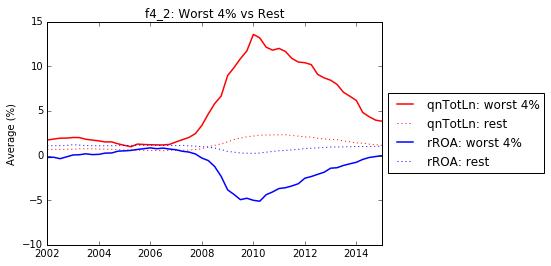

In [207]:
## f4_2 model:
plt.plot(xg,wg2['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
plt.plot(xg,wg2['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg2['rROA',1],c='b',lw=1.5,label='rROA: worst 4%')
plt.plot(xg,wg2['rROA',0],c='b',ls=':',label='rROA: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_2: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_2_wrst4_qn_roa.png', dpi=300, bbox_inches='tight')
plt.show()

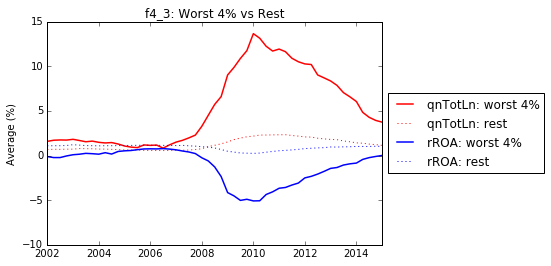

In [208]:
## YES... use this
## f4_3 model:
plt.plot(xg,wg3['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
#plt.plot(xg,wg3['qnTotLn',1],c='r',ls='--',label='qnTotLn: worst 4%')
plt.plot(xg,wg3['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg3['rROA',1],c='b',lw=1.5,label='rROA: worst 4%')
#plt.plot(xg,wg3['rROA',1],c='b',ls='--',label='rROA: worst 4%')
plt.plot(xg,wg3['rROA',0],c='b',ls=':',label='rROA: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_3: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_3_wrst4_qn_roa.png', dpi=300, bbox_inches='tight')
plt.show()

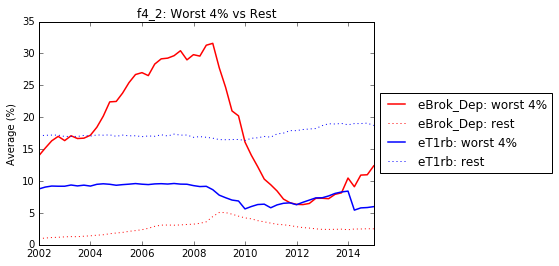

In [209]:
## YES, use this
#f4_2 model:
plt.plot(xg,wg2['eBrok_Dep',1],c='r',lw=1.5,label='eBrok_Dep: worst 4%')
plt.plot(xg,wg2['eBrok_Dep',0],c='r',ls=':',label='eBrok_Dep: rest')
plt.plot(xg,wg2['eT1rb',1],c='b',lw=1.5,label='eT1rb: worst 4%')
plt.plot(xg,wg2['eT1rb',0],c='b',ls=':',label='eT1rb: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_2: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_2_wrst4_brok_t1.png', dpi=300, bbox_inches='tight')
plt.show()

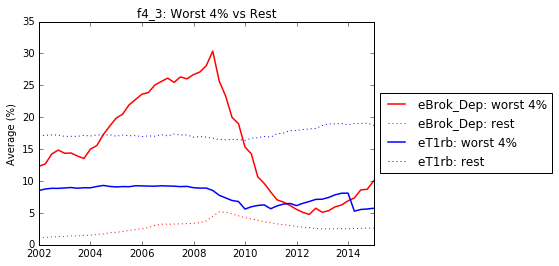

In [210]:
# YES, use this
#f4_3 model:
plt.plot(xg,wg3['eBrok_Dep',1],c='r',lw=1.5,label='eBrok_Dep: worst 4%')
#plt.plot(xg,wg3['eBrok_Dep',1],c='r',ls='--',label='eBrok_Dep: worst 4%')
plt.plot(xg,wg3['eBrok_Dep',0],c='r',ls=':',label='eBrok_Dep: rest')
plt.plot(xg,wg3['eT1rb',1],c='b',lw=1.5,label='eT1rb: worst 4%')
#plt.plot(xg,wg3['eT1rb',1],c='b',ls='--',label='eT1rb: worst 4%')
plt.plot(xg,wg3['eT1rb',0],c='b',ls=':',label='eT1rb: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_3: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_3_wrst4_brok_t1.png', dpi=300, bbox_inches='tight')
plt.show()

In [211]:
vlst = ['eT1rb','qnTotLn','rROE','eBrok_Dep']
tlst = ['Tier 1 Risk-Based Capital Ratio','Non-Accrual Loans','Rolling 4q ROE','Brokered Deposit Ratio']
vlst, tlst

(['eT1rb', 'qnTotLn', 'rROE', 'eBrok_Dep'],
 ['Tier 1 Risk-Based Capital Ratio',
  'Non-Accrual Loans',
  'Rolling 4q ROE',
  'Brokered Deposit Ratio'])

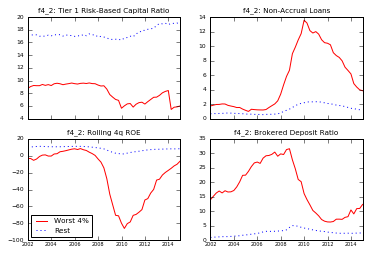

In [212]:
plt.rcParams.update({'font.size': 6})
xax = xg
ver = 0     ## 0, 1, 2 only
for i in np.arange(4):
  plt.subplot(2, 2, i+1)
  plt.plot(xg,wg2[vlst[i],1],c='r',lw=1,label='Worst 4%')
  plt.plot(xg,wg2[vlst[i],0],c='b',ls=':',label='Rest')
  if i == 2: plt.legend(loc=0)
#  plt.grid()
  plt.title("f4_2: "+tlst[i])

  if i < 2:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 5,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off


plt.savefig('f4_2_4vars_wrst4vsrest'+'.png', dpi=400, bbox_inches='tight')
plt.show()


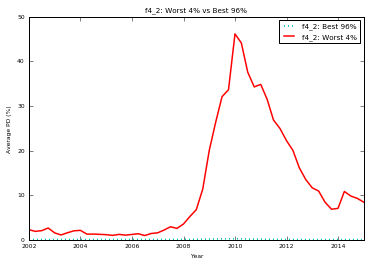

In [213]:
### f4_2 model:
xx2 = wg2['f4_2'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[0],c='c',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[1],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: Worst 4% vs Best 96%')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('f4_2_wrst4_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

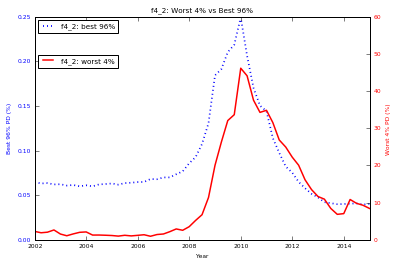

In [214]:
xx2 = wg2['f4_2'] * 100  # convert to units of %

ax1 = plt.gca()
ax1.plot(xg,xx2[0],c='b',ls=':',lw=1.7,label='f4_2: best 96%')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[1],c='r',lw=1.5,label='f4_2: worst 4%')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.8))

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')
plt.show()

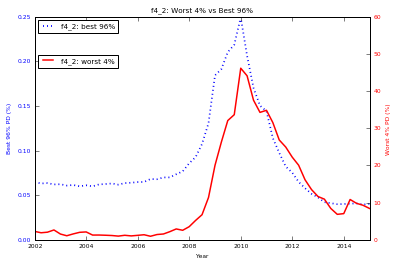

In [215]:
### second y-axis:
### f4_2 model:
xx2 = wg2['f4_2'] * 100  # convert to units of %

fig, ax1 = plt.subplots()
ax1.plot(xg,xx2[0],c='b',ls=':',lw=1.7,label='f4_2: best 96%')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[1],c='r',lw=1.5,label='f4_2: worst 4%')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.8))

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')

#plt.ylim([0,.1])
plt.savefig('f4_2_wrst4_modpd_sec_yaxis.png', dpi=300, bbox_inches='tight')
plt.show()

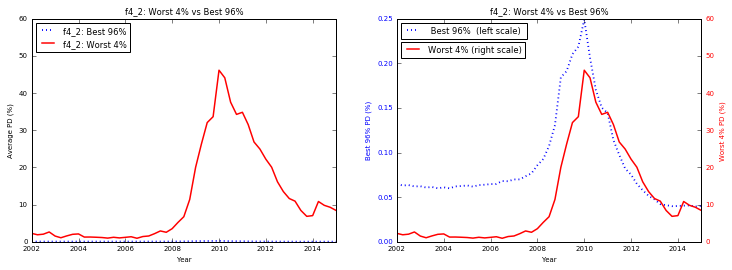

In [216]:
plt.rcParams.update({'font.size': 7})
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
xx2 = wg2['f4_2'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[0],c='b',ls=':',lw=1.8,label='f4_2: Best 96%')
plt.plot(xg,xx2[1],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: Worst 4% vs Best 96%')
plt.legend(loc=2)
plt.ylim([0,60])
plt.ylabel('Average PD (%)')
plt.xlabel('Year')

plt.subplot(1, 2, 2)
ax1 = plt.gca()
ax1.plot(xg,xx2[0],c='b',ls=':',lw=1.8,label=' Best 96%  (left scale) ')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[1],c='r',lw=1.5,label='Worst 4% (right scale)')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.86))

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')

plt.savefig('f4_2_wrst4bst96_modpd_2charts.png', dpi=300, bbox_inches='tight')
plt.show()

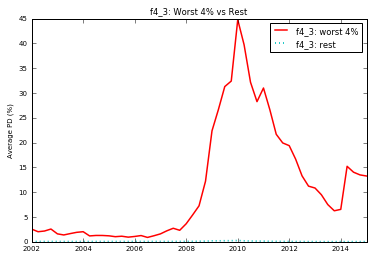

In [217]:
### f4_3 model:
xx3 = wg3['f4_3'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx3[1],c='r',lw=1.5,label='f4_3: worst 4%')
#plt.plot(xg,xx3[1],c='c',ls='--',label='f4_3: worst 4%')
plt.plot(xg,xx3[0],c='c',ls=':',lw=1.7,label='f4_3: rest')
plt.title('f4_3: Worst 4% vs Rest')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
#plt.ylim([0,.1])
plt.savefig('f4_3_wrst4_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

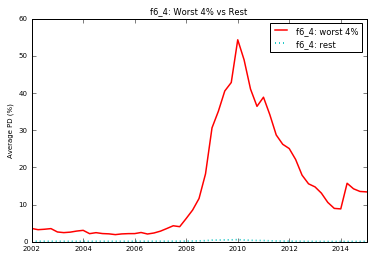

In [218]:
### f6_4 model:
xx4 = wg4['f6_4'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx4[1],c='r',lw=1.5,label='f6_4: worst 4%')
plt.plot(xg,xx4[0],c='c',ls=':',lw=1.7,label='f6_4: rest')
plt.title('f6_4: Worst 4% vs Rest')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
#plt.ylim([0,.1])
plt.savefig('f6_4_wrst4_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

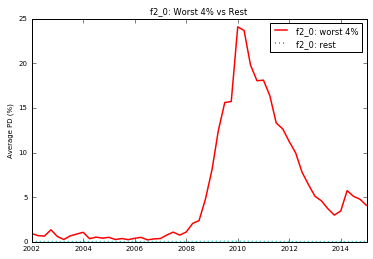

In [219]:
### f2_0 model:
xx0 = wg0['f2_0'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx0[1],c='r',lw=1.5,label='f2_0: worst 4%')
plt.plot(xg,xx0[0],c='c',ls=':',lw=1.7,label='f2_0: rest')
plt.title('f2_0: Worst 4% vs Rest')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
#plt.ylim([0,.1])
plt.savefig('f2_0_wrst4_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

In [220]:
xx2['2009':'2011']

0          1          2
AsOf                                      
2009-03-31  0.191137  26.259376  33.670506
2009-06-30  0.210189  32.051848  40.930429
2009-09-30  0.218495  33.634028  42.496402
2009-12-31  0.249135  46.124939  58.232900
2010-03-31  0.206080  44.085461  55.891143
2010-06-30  0.170171  37.531169  48.017703
2010-09-30  0.150247  34.249278  43.962717
2010-12-31  0.144118  34.813381  44.739387
2011-03-31  0.113952  31.516361  40.620193
2011-06-30  0.097345  26.832328  34.662839
2011-09-30  0.082066  24.934060  32.299705
2011-12-31  0.075252  22.223061  28.865227

In [221]:
xx3['2009':'2011']

0          1          2
AsOf                                      
2009-03-31  0.193076  26.625971  34.062402
2009-06-30  0.212228  31.295576  39.827866
2009-09-30  0.217682  32.407485  40.771869
2009-12-31  0.252017  44.765222  56.334446
2010-03-31  0.195283  39.726822  50.320525
2010-06-30  0.157233  32.173634  40.987888
2010-09-30  0.135445  28.257976  36.071253
2010-12-31  0.135417  31.005599  39.570783
2011-03-31  0.100920  26.645348  34.171497
2011-06-30  0.084134  21.673457  27.802051
2011-09-30  0.070004  19.933069  25.675480
2011-12-31  0.065578  19.383170  25.023491

In [222]:
wg2.columns.levels[0]

Index([u'aFF_TA', u'eALLL_Ln', u'eBrok_Dep', u'eLn_Dep', u'eT1rb', u'eTotrb',
       u'f4', u'f4_2', u'lnTotAst', u'qnTotLn', u'rEff', u'rNIM', u'rPPNR',
       u'rROA', u'rROE', u'rcTotLn'],
      dtype='object')

In [223]:
wg0.to_csv("f2_0_vars_worst3worst4rest.csv")
wg1.to_csv("f2_1_vars_worst3worst4rest.csv")
wg2.to_csv("f4_2_vars_worst3worst4rest.csv")
wg3.to_csv("f4_3_vars_worst3worst4rest.csv")
wg4.to_csv("f6_4_vars_worst3worst4rest.csv")
wg5.to_csv("f6_5_vars_worst3worst4rest.csv")

In [224]:
dff.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'State', u'eTotAst', u'rcTotLn',
       u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep',
       u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst',
       u'FailDate', u'mtf', u'mtf2', u'f2', u'f4', u'f6', u'f8', u'Intercept',
       u'f2_0', u'f2_1', u'f4_2', u'f4_3', u'f6_4', u'f6_5', u'f2_0rr',
       u'f2_1rr', u'f4_2rr', u'f4_3rr', u'f6_4rr', u'f6_5rr', u'f2_lnTotAst',
       u'f4_lnTotAst', u'f6_lnTotAst', u'f2_rROE', u'f4_rROE', u'f6_rROE',
       u'f2_rROA', u'f4_rROA', u'f6_rROA', u'f2_eT1rb', u'f4_eT1rb',
       u'f6_eT1rb', u'f2_qnTotLn', u'f4_qnTotLn', u'f6_qnTotLn',
       u'f2_eBrok_Dep', u'f4_eBrok_Dep', u'f6_eBrok_Dep', u'f2_eLn_Dep',
       u'f4_eLn_Dep', u'f6_eLn_Dep', u'f2_aFF_TA', u'f4_aFF_TA', u'f6_aFF_TA'],
      dtype='object')

In [225]:
len(dffw)

395257

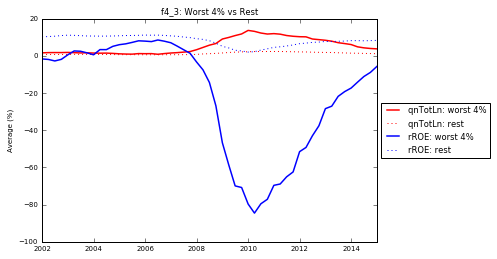

In [226]:
# NO, not needed
###f4_3 model:
plt.plot(xg,wg3['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
#plt.plot(xg,wg3['qnTotLn',1],c='r',ls='--',label='qnTotLn: worst 4%')
plt.plot(xg,wg3['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg3['rROE',1],c='b',lw=1.5,label='rROE: worst 4%')
#plt.plot(xg,wg3['rROE',1],c='b',ls='--',label='rROE: worst 4%')
plt.plot(xg,wg3['rROE',0],c='b',ls=':',label='rROE: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_3: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_3_wrst4_qn_roe.png', dpi=300, bbox_inches='tight')
plt.show()

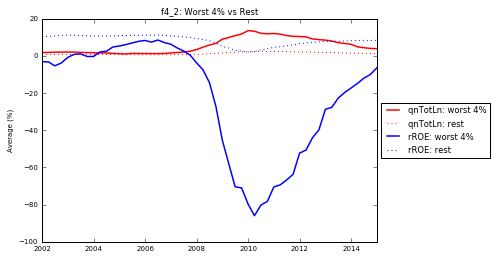

In [227]:
# YES, use this
###f4_2 model:
plt.plot(xg,wg2['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
#plt.plot(xg,wg2['qnTotLn',1],c='r',ls='--',label='qnTotLn: worst 4%')
plt.plot(xg,wg2['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg2['rROE',1],c='b',lw=1.5,label='rROE: worst 4%')
#plt.plot(xg,wg2['rROE',1],c='b',ls='--',label='rROE: worst 4%')
plt.plot(xg,wg2['rROE',0],c='b',ls=':',label='rROE: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_2: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_2_wrst4_qn_roe.png', dpi=300, bbox_inches='tight')
plt.show()

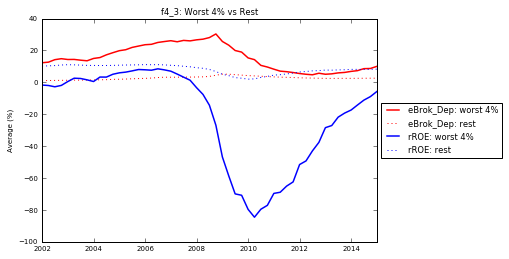

In [228]:
# NO not needed
###f4_3 model:
plt.plot(xg,wg3['eBrok_Dep',1],c='r',lw=1.5,label='eBrok_Dep: worst 4%')
#plt.plot(xg,wg3['eBrok_Dep',1],c='r',ls='--',label='eBrok_Dep: wrst 4%')
plt.plot(xg,wg3['eBrok_Dep',0],c='r',ls=':',label='eBrok_Dep: rest')
plt.plot(xg,wg3['rROE',1],c='b',lw=1.5,label='rROE: worst 4%')
#plt.plot(xg,wg3['rROE',1],c='b',ls='--',label='rROE: worst 4%')
plt.plot(xg,wg3['rROE',0],c='b',ls=':',label='rROE: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_3: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_3_wrst4_brok_roe.png', dpi=300, bbox_inches='tight')
plt.show()

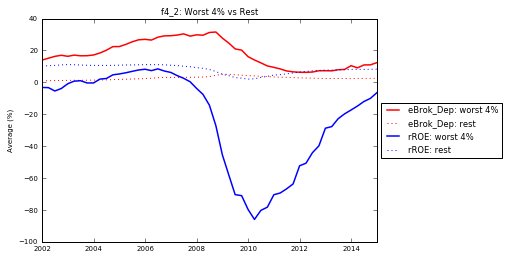

In [229]:
# NO net needed
###f4_2 model:
plt.plot(xg,wg2['eBrok_Dep',1],c='r',lw=1.5,label='eBrok_Dep: worst 4%')
#plt.plot(xg,wg2['eBrok_Dep',1],c='r',ls='--',label='eBrok_Dep: worst 4%')
plt.plot(xg,wg2['eBrok_Dep',0],c='r',ls=':',label='eBrok_Dep: rest')
plt.plot(xg,wg2['rROE',1],c='b',lw=1.5,label='rROE: worst 4%')
#plt.plot(xg,wg2['rROE',1],c='b',ls='--',label='rROE: worst 4%')
plt.plot(xg,wg2['rROE',0],c='b',ls=':',label='rROE: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_2: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_2_wrst4_brok_roe.png', dpi=300, bbox_inches='tight')
plt.show()

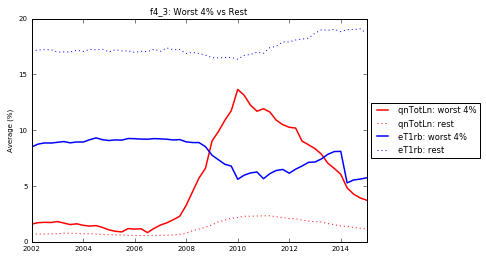

In [230]:
# NO not needed
###f4_3 model:
plt.plot(xg,wg3['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
#plt.plot(xg,wg3['qnTotLn',1],c='r',ls='--',label='qnTotLn: worst 4%')
plt.plot(xg,wg3['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg3['eT1rb',1],c='b',lw=1.5,label='eT1rb: worst 4%')
#plt.plot(xg,wg3['eT1rb',1],c='b',ls='--',label='eT1rb: worst 4%')
plt.plot(xg,wg3['eT1rb',0],c='b',ls=':',label='eT1rb: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_3: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_3_wrst4_qn_t1.png', dpi=300, bbox_inches='tight')
plt.show()

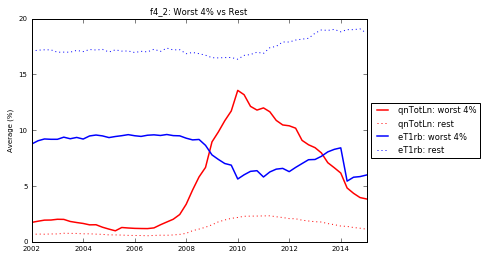

In [231]:
# NO not needed
###f4_2 model:
plt.plot(xg,wg2['qnTotLn',1],c='r',lw=1.5,label='qnTotLn: worst 4%')
#plt.plot(xg,wg2['qnTotLn',1],c='r',ls='--',label='qnTotLn: worst 4%')
plt.plot(xg,wg2['qnTotLn',0],c='r',ls=':',label='qnTotLn: rest')
plt.plot(xg,wg2['eT1rb',1],c='b',lw=1.5,label='eT1rb: worst 4%')
#plt.plot(xg,wg2['eT1rb',1],c='b',ls='--',label='eT1rb: worst 4%')
plt.plot(xg,wg2['eT1rb',0],c='b',ls=':',label='eT1rb: rest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('f4_2: Worst 4% vs Rest')
plt.ylabel('Average (%)')
plt.savefig('f4_2_wrst4_qn_t1.png', dpi=300, bbox_inches='tight')
plt.show()

In [232]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
1  1.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
2  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517801   
3  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520142   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  5.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611861 -2.799513 -0.473053 -0.024954  0.084635  0.034710  
1   lnTotAst  0.605720 -6.621654 -0.450486 -0.028629  0.084572  0.310082  
2  eBrok_Dep  0.544656 -2.201036 -0.406007  0.112216 -0.028424  0.041344  
3  eBrok_Dep  0.543210 -0.956072 -0.525634  0.116850 -0.306411  0.038855  
4       rROA  0.460012 -1.300542 -0.419816  0.145885  0.042008 -0.286718  
5       rROE  0.458435 -2.075058 -0.346648  0.140151  0.043325 -0.025627